In [1]:
R.version

               _                                
platform       x86_64-w64-mingw32               
arch           x86_64                           
os             mingw32                          
crt            ucrt                             
system         x86_64, mingw32                  
status                                          
major          4                                
minor          4.2                              
year           2024                             
month          10                               
day            31                               
svn rev        87279                            
language       R                                
version.string R version 4.4.2 (2024-10-31 ucrt)
nickname       Pile of Leaves                   

# 1. Initialization

In [4]:
# PACKAGES & CONSTANTS DECLARATIONS #
#####################################

# Function to install missing packages
InstallPackages <- function(oPackageList) {
  for (sPackage in oPackageList) {
    if (!require(sPackage, character.only = TRUE)) {
      install.packages(sPackage, repos = "http://cran.r-project.org")
      library(sPackage, character.only = TRUE)
    }
  }
}

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# List of required packages
oRequiredPackages <- c("sfsmisc","sparsepca", "elasticnet","reshape2", "ggplot2", "tidyr", "dplyr", "MASS", "Matrix", "stats", "doParallel")

# Install missing packages
InstallPackages(oRequiredPackages)

global_iRandomSeed <- 13654
set.seed(global_iRandomSeed)  # for reproducibility

# Constants for data dimensions
N_OBSERVATIONS <- 600
N_VARIABLES <- 1200
global_UseParallelization = 1
global_bZeroImputationBehaviour = 1
global_TrainTestRatio = 0.7

# If needed, enable CPU cores parallelization #
if (global_UseParallelization == 1) {
    library(doParallel)
    global_iCoreNumber <- detectCores() - 1
    registerDoParallel(cores = global_iCoreNumber)
}

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Duration :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-08 10:43:30"


Le chargement a nécessité le package : sfsmisc

Le chargement a nécessité le package : sparsepca

Le chargement a nécessité le package : elasticnet

Le chargement a nécessité le package : lars

Loaded lars 1.3


Registered S3 method overwritten by 'elasticnet':
  method     from     
  print.spca sparsepca


Attachement du package : 'elasticnet'


L'objet suivant est masqué depuis 'package:sparsepca':

    spca


Le chargement a nécessité le package : reshape2

Le chargement a nécessité le package : ggplot2

Le chargement a nécessité le package : tidyr


Attachement du package : 'tidyr'


L'objet suivant est masqué depuis 'package:reshape2':

    smiths


Le chargement a nécessité le package : dplyr


Attachement du package : 'dplyr'


L'objet suivant est masqué depuis 'package:sfsmisc':

    last


Les objets suivants sont masqués depuis 'package:stats':

    filter, lag


Les objets suivants sont masqués depuis 'package:base':

    intersect, setdiff, setequal, union


Le chargement 

[1] "Current Time : 2024-12-08 10:43:32"
[1] "Duration : 1.626 seconds"


# 2. Data Generation

In [6]:
Get_Preprocessed_Data <- function(oDataSet) {
  Get_the_Mode <- function(x) {
    ux <- unique(na.omit(x))
    ux[which.max(tabulate(match(x, ux)))]
  }

  if (global_bZeroImputationBehaviour == 1) {
      oDataSet <- oDataSet %>%
        mutate(across(where(is.numeric), ~ if_else((is.na(.) | (. == 0)), mean(., na.rm = TRUE), .)))
  } else if (global_bZeroImputationBehaviour == 0) {    
      oDataSet <- oDataSet %>%
        mutate(across(where(is.numeric), ~ if_else(is.na(.), mean(., na.rm = TRUE), .)))
  }

  # Replace NA by the mode.
  oDataSet <- oDataSet %>%
    mutate(across(where(is.factor), ~ if_else(is.na(.), Get_the_Mode(.), .)))

  return(oDataSet)
}

In [8]:
# DATASET 02 => Air Pollution_Challenge        #
################################################

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

oDataMatrix <- read.csv("Pollution_Train.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)

oDataMatrix <- Get_Preprocessed_Data(oDataMatrix)

if (!is.null(oDataMatrix)) {
  oDataMatrix <- oDataMatrix[, sapply(oDataMatrix, is.numeric), drop = FALSE]
  oDataMatrix <- as.data.frame(lapply(oDataMatrix, as.double))
  oDataMatrix <- as.data.frame(lapply(oDataMatrix, function(col) as.numeric(as.character(col))))
  
  if (any(is.na(oDataMatrix))) {
    warning("NA after conversion.")
    oDataMatrix <- na.omit(oDataMatrix)
  }
} else {
  stop("oDataMatrix is NULL. Please provide a valid dataset.")
}

oDataMatrix <- as.matrix(oDataMatrix)

cat("Dimensions Matrix : ", dim(oDataMatrix), "\n")
head(oDataMatrix)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Duration :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-08 10:43:36"
Dimensions Matrix :  30557 79 


target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,⋯,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
38,23,53,769.50,92,11.000000,60.2,0.00804000,18.51684,1.996377,⋯,38.5930174,-61.75259,22.36366,1793.7936,3227.855,0.01057904,74.481049,37.50150,-62.14264,22.54512
39,25,63,1319.85,91,14.600000,48.8,0.00839000,22.54653,3.330430,⋯,59.6249116,-67.69351,28.61480,1789.9604,3384.227,0.01510438,75.630043,55.65749,-53.86813,19.29365
24,8,56,1181.96,96,16.400000,33.4,0.00750000,27.03103,5.065727,⋯,49.8397137,-78.34270,34.29698,923.2319,1711.794,0.01622666,1.254703,13.84904,-69.09859,23.10063
49,10,55,1113.67,96,6.911948,21.3,0.00391000,23.97186,3.004001,⋯,29.1812580,-73.89659,30.54545,923.2319,1711.794,0.01622666,1.254703,13.84904,-69.09859,23.10063
21,9,52,1164.82,95,13.900001,44.7,0.00535000,16.81631,2.621787,⋯,0.7972941,-68.61248,26.89969,923.2319,1711.794,0.01622666,1.254703,13.84904,-69.09859,23.10063
28,10,52,1053.22,94,14.600000,42.2,0.00586156,19.17489,2.955603,⋯,30.6051757,-62.13426,23.41999,923.2319,1711.794,0.01622666,1.254703,13.84904,-69.09859,23.10063


[1] "Current Time : 2024-12-08 10:43:43"
[1] "Duration : 7.143 seconds"


# 3. Data Exploration

In [11]:
# Define train and test sets             #
##########################################

iTrainIndices <- sample(1:nrow(oDataMatrix), size = global_TrainTestRatio * nrow(oDataMatrix))
oTrainData <- oDataMatrix[iTrainIndices, ]
oTestData <- oDataMatrix[-iTrainIndices, ]  # Remaining data for testing

In [13]:
dim(oDataMatrix)
dim(oTrainData)
dim(oTestData)

cat("Colunms : ", colnames(oDataMatrix), "\n")

[1] 30557    79

[1] 21389    79

[1] 9168   79

Colunms :  target target_min target_max target_variance target_count precipitable_water_entire_atmosphere relative_humidity_2m_above_ground specific_humidity_2m_above_ground temperature_2m_above_ground u_component_of_wind_10m_above_ground v_component_of_wind_10m_above_ground L3_NO2_NO2_column_number_density L3_NO2_NO2_slant_column_number_density L3_NO2_absorbing_aerosol_index L3_NO2_cloud_fraction L3_NO2_sensor_altitude L3_NO2_sensor_azimuth_angle L3_NO2_sensor_zenith_angle L3_NO2_solar_azimuth_angle L3_NO2_solar_zenith_angle L3_NO2_stratospheric_NO2_column_number_density L3_NO2_tropopause_pressure L3_NO2_tropospheric_NO2_column_number_density L3_O3_O3_column_number_density L3_O3_O3_effective_temperature L3_O3_cloud_fraction L3_O3_sensor_azimuth_angle L3_O3_sensor_zenith_angle L3_O3_solar_azimuth_angle L3_O3_solar_zenith_angle L3_CO_CO_column_number_density L3_CO_H2O_column_number_density L3_CO_cloud_height L3_CO_sensor_altitude L3_CO_sensor_azimuth_angle L3_CO_sensor_zenith_angle L3_C

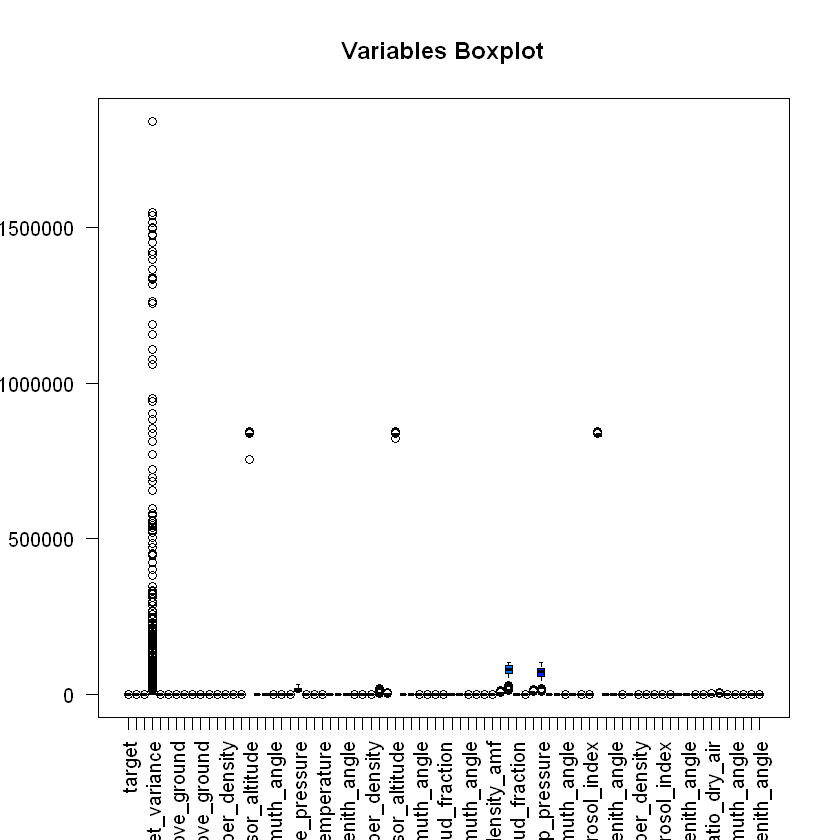

In [15]:
boxplot(oDataMatrix, las = 2, col = rainbow(ncol(oDataMatrix)), main = "Variables Boxplot")

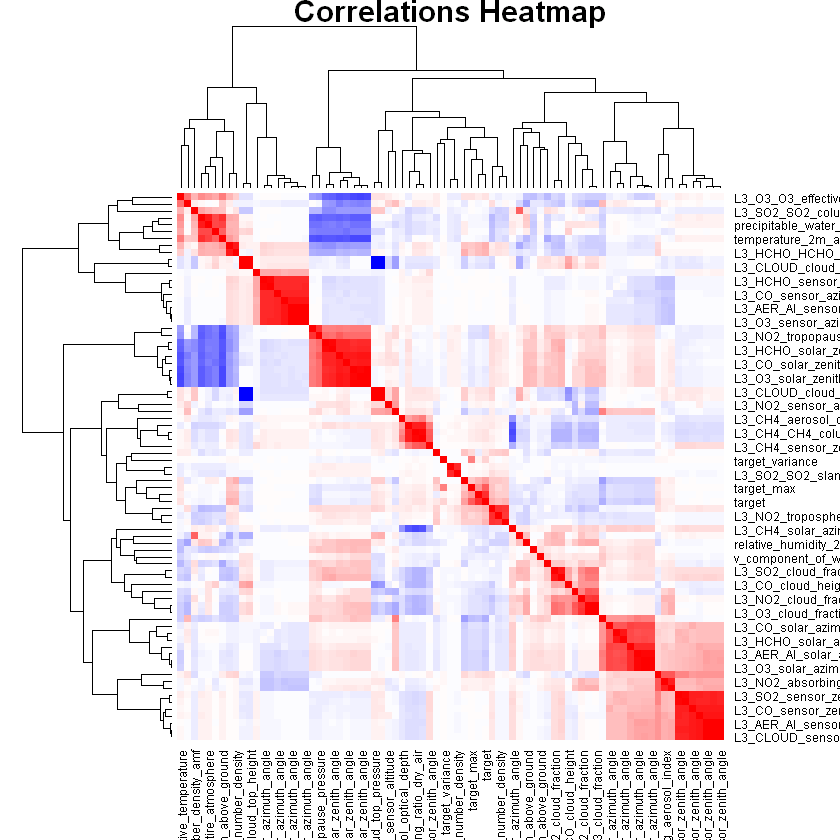

In [17]:
##########################################
# Correlation Matrix                     #
##########################################

cor_matrix <- cor(oDataMatrix)

# Correlations Heatmap
heatmap(cor_matrix, symm = TRUE, col = colorRampPalette(c("blue", "white", "red"))(100),
        main = "Correlations Heatmap")

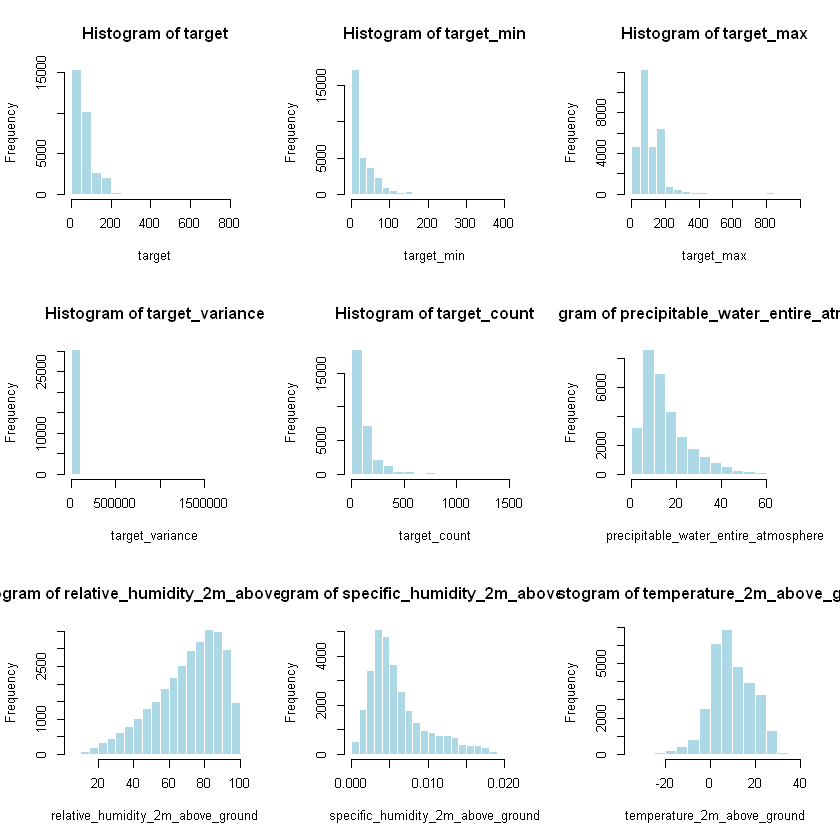

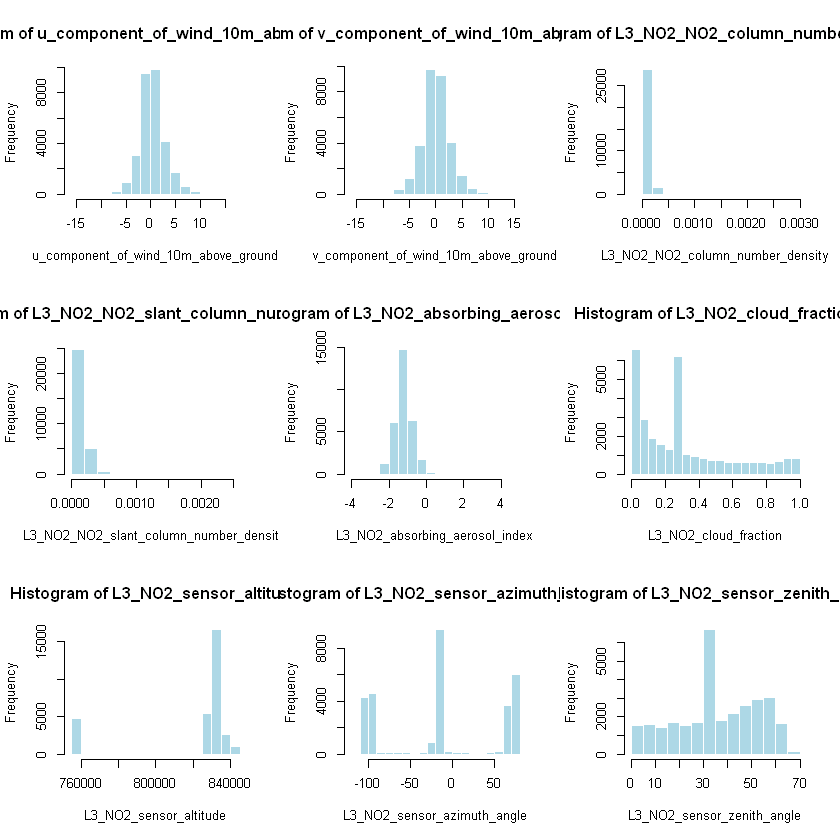

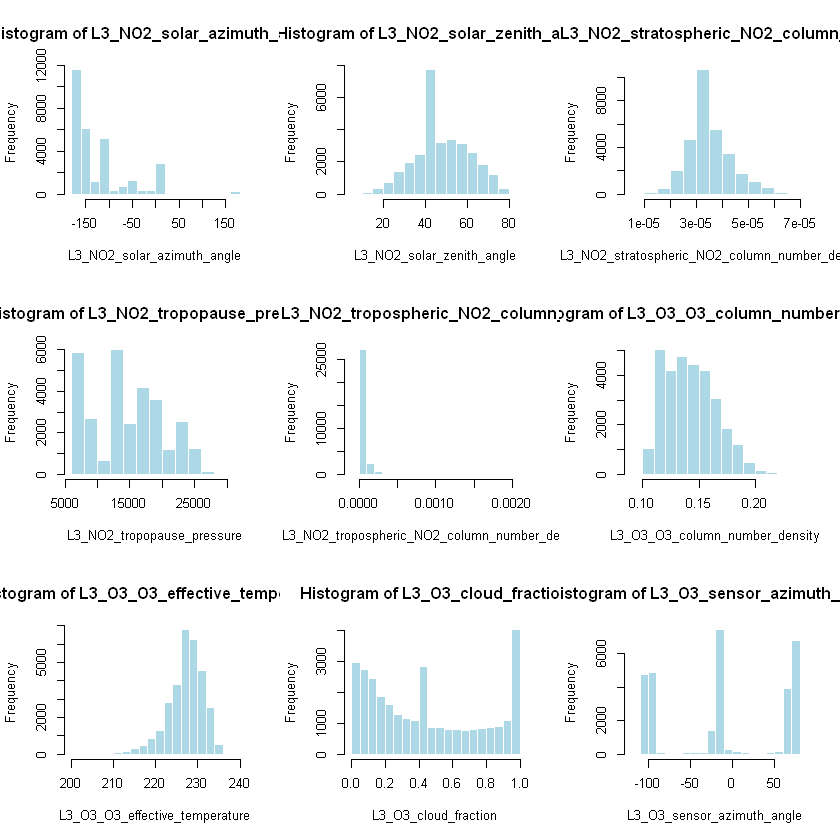

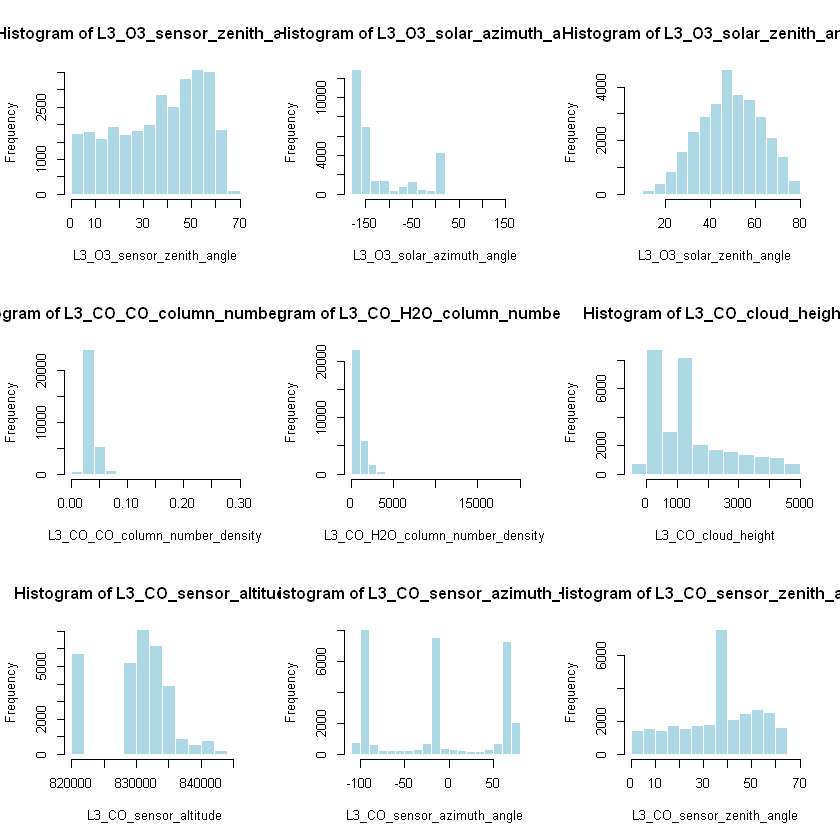

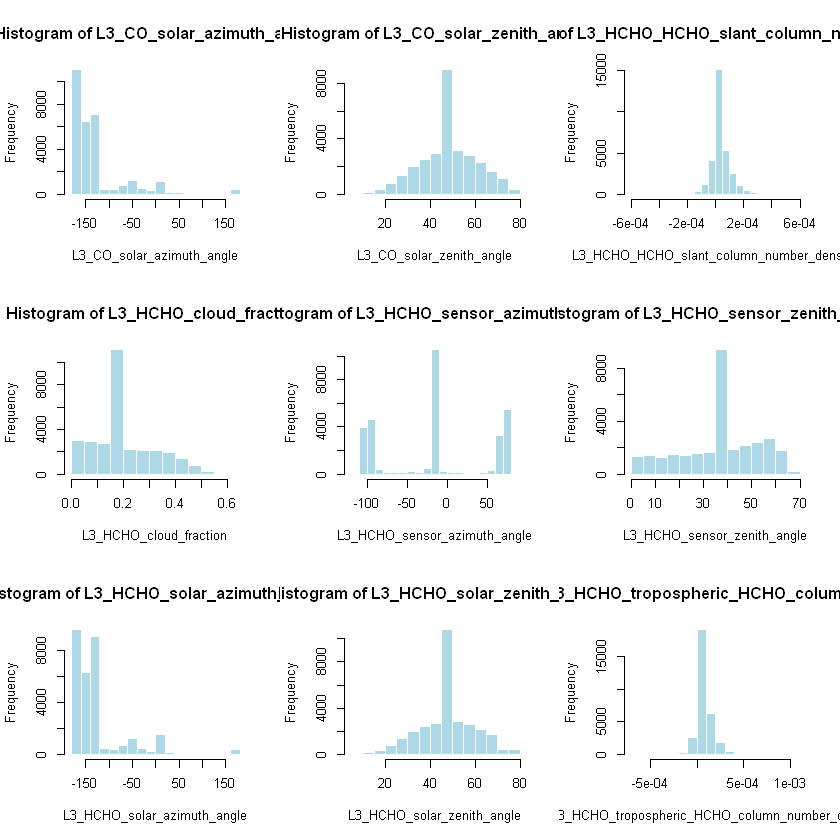

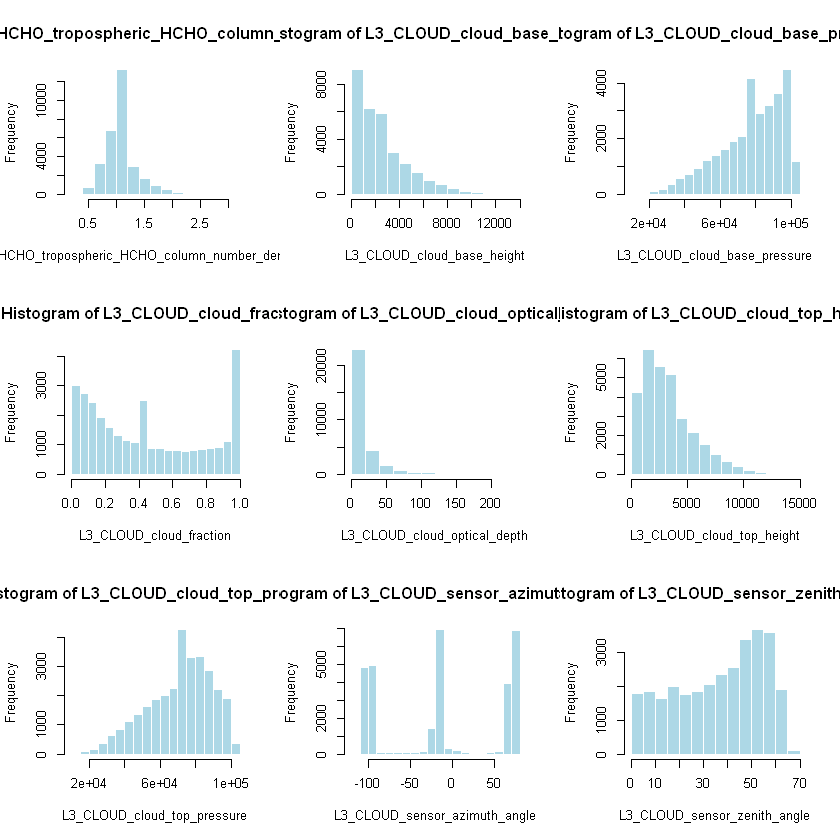

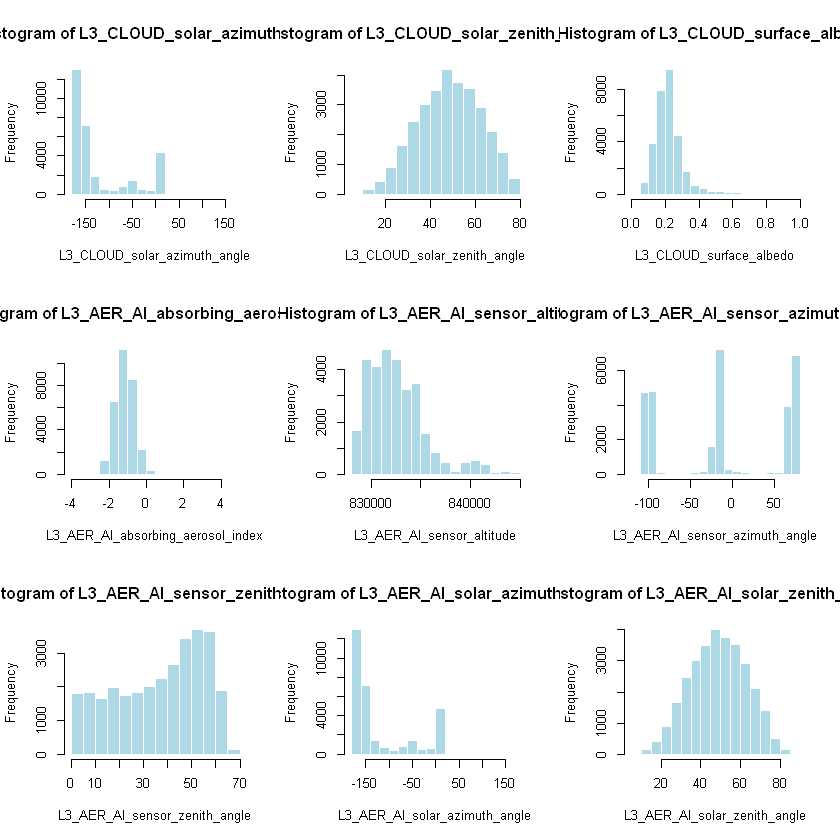

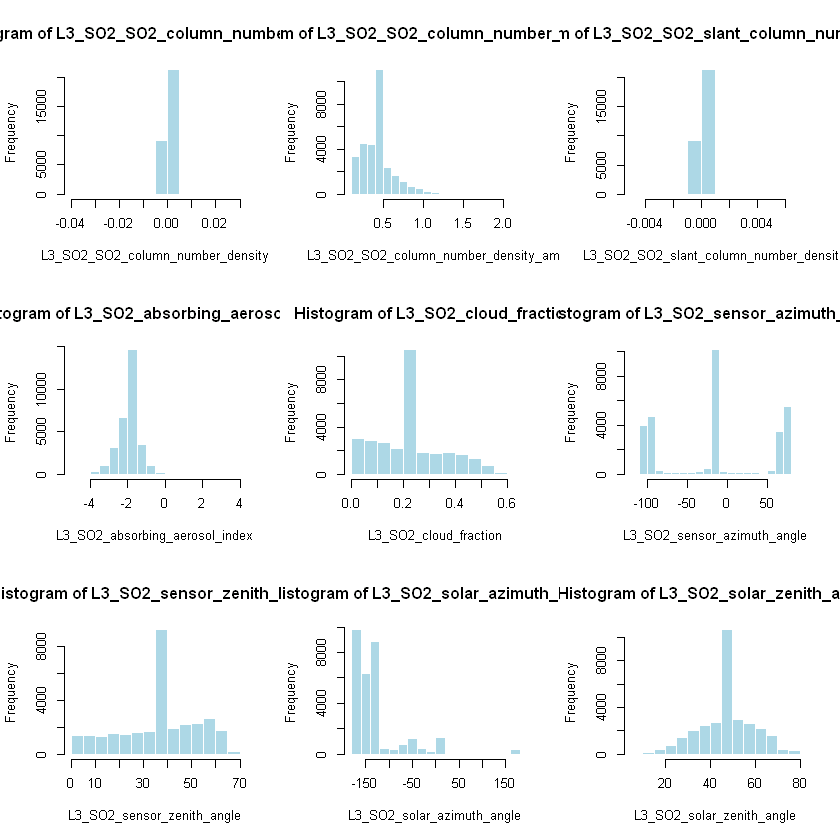

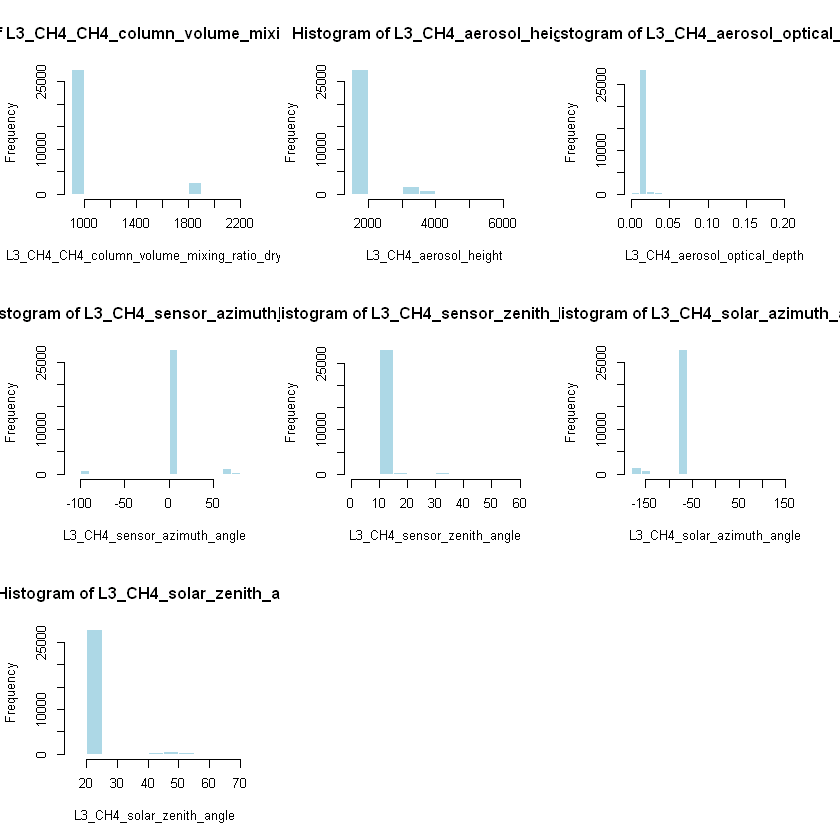

In [19]:
##########################################
# Histograms for each variable           #
##########################################

par(mfrow = c(3, 3))  # Arrange plots in a grid
for (col in colnames(oDataMatrix)) {
    hist(oDataMatrix[, col], main = paste("Histogram of", col), xlab = col, col = "lightblue", border = "white")
}
par(mfrow = c(1, 1))  # Reset plot layout


Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     3.3793 3.0080 2.57551 2.51496 2.22038 2.03966 1.77036
Proportion of Variance 0.1446 0.1145 0.08397 0.08006 0.06241 0.05266 0.03967
Cumulative Proportion  0.1446 0.2591 0.34304 0.42311 0.48551 0.53818 0.57785
                           PC8     PC9    PC10    PC11    PC12   PC13    PC14
Standard deviation     1.70478 1.52971 1.39285 1.34920 1.32975 1.2379 1.18634
Proportion of Variance 0.03679 0.02962 0.02456 0.02304 0.02238 0.0194 0.01782
Cumulative Proportion  0.61464 0.64426 0.66881 0.69186 0.71424 0.7336 0.75145
                          PC15    PC16    PC17    PC18    PC19   PC20    PC21
Standard deviation     1.10929 1.07153 1.04920 0.97294 0.96743 0.9489 0.91138
Proportion of Variance 0.01558 0.01453 0.01393 0.01198 0.01185 0.0114 0.01051
Cumulative Proportion  0.76703 0.78156 0.79550 0.80748 0.81933 0.8307 0.84124
                          PC22    PC23    

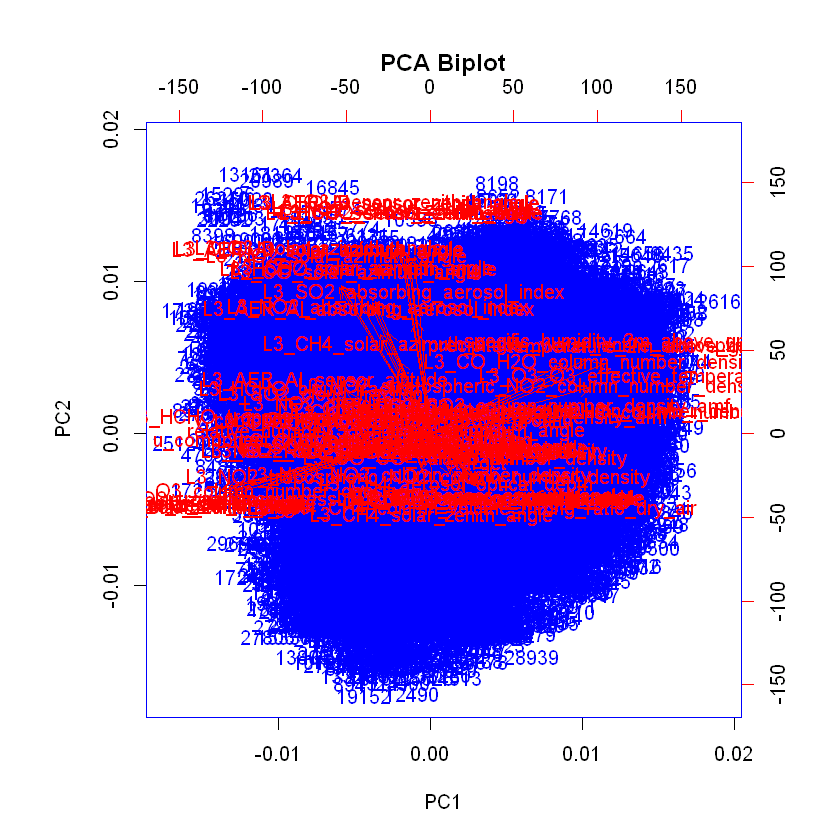

In [21]:
##########################################
# PCA Simple                             #
##########################################

pca_res <- prcomp(oDataMatrix, center = TRUE, scale. = TRUE)

# Summary of principal components
summary(pca_res)

# Biplot of the first two principal components
biplot(pca_res, main = "PCA Biplot", col = c("blue", "red"))


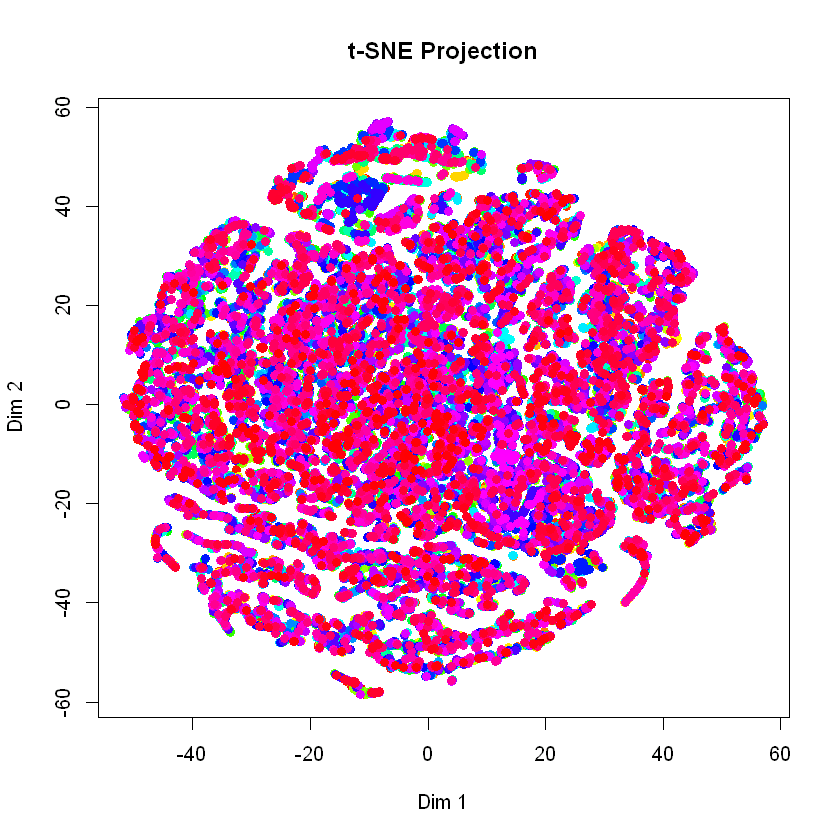

In [23]:
##########################################
# t-SNE Visualization                    #
##########################################

# Reduce dimensionality using t-SNE and visualize clusters.

if (!requireNamespace("Rtsne", quietly = TRUE)) {
    install.packages("Rtsne")
}
library(Rtsne)

# t-SNE
tsne_res <- Rtsne(oDataMatrix, dims = 2, perplexity = 15)

# Visualize t-SNE results
plot(tsne_res$Y, main = "t-SNE Projection", xlab = "Dim 1", ylab = "Dim 2",
     col = rainbow(length(tsne_res$Y[,1])), pch = 19)

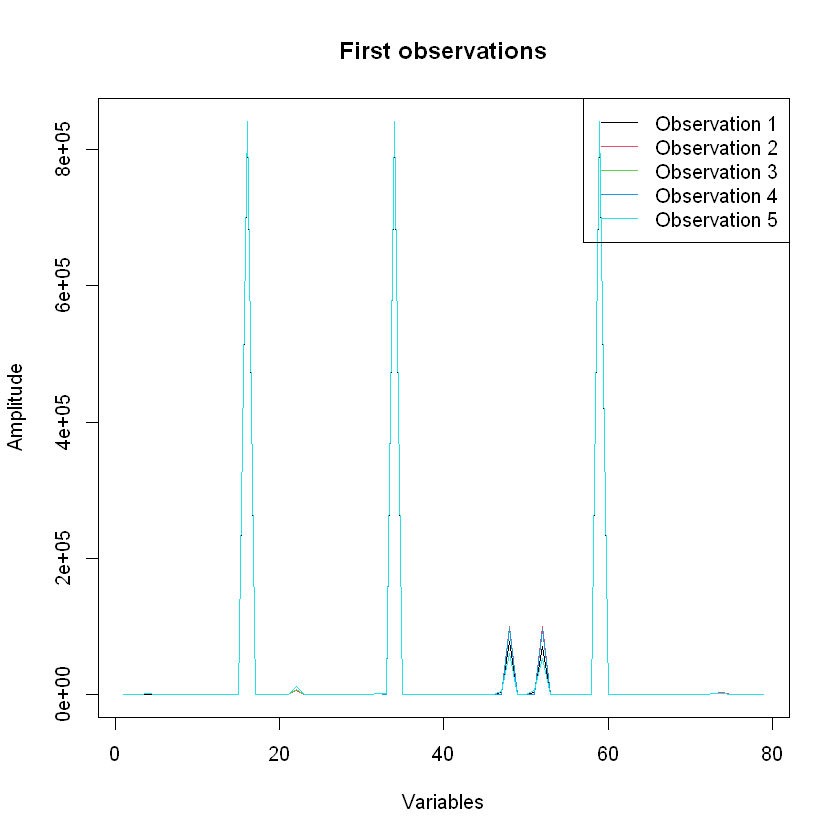

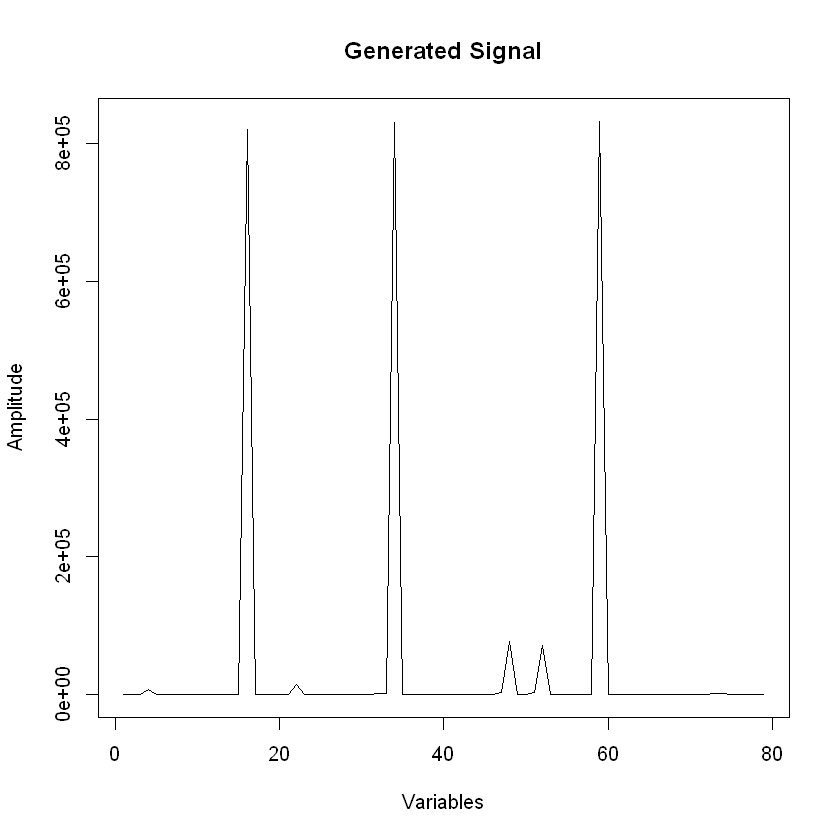

In [24]:
# Ploting first observations             #
##########################################

matplot(t(oDataMatrix[1:5, ]), type = "l", lty = 1, col = 1:5,
        main = "First observations",
        xlab = "Variables", ylab = "Amplitude")
legend("topright", legend = paste("Observation", 1:5), col = 1:5, lty = 1)

# Ploting mean of the generated signal   #
##########################################

mean_signal <- colMeans(oDataMatrix)

plot(mean_signal, type = "l", main = "Generated Signal", xlab = "Variables", ylab = "Amplitude")

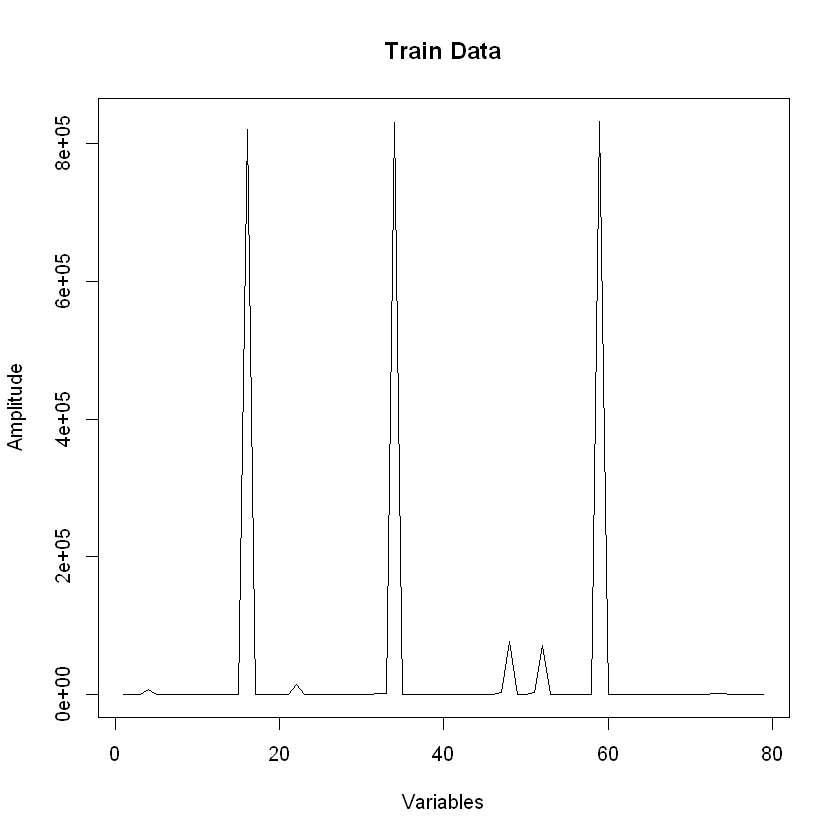

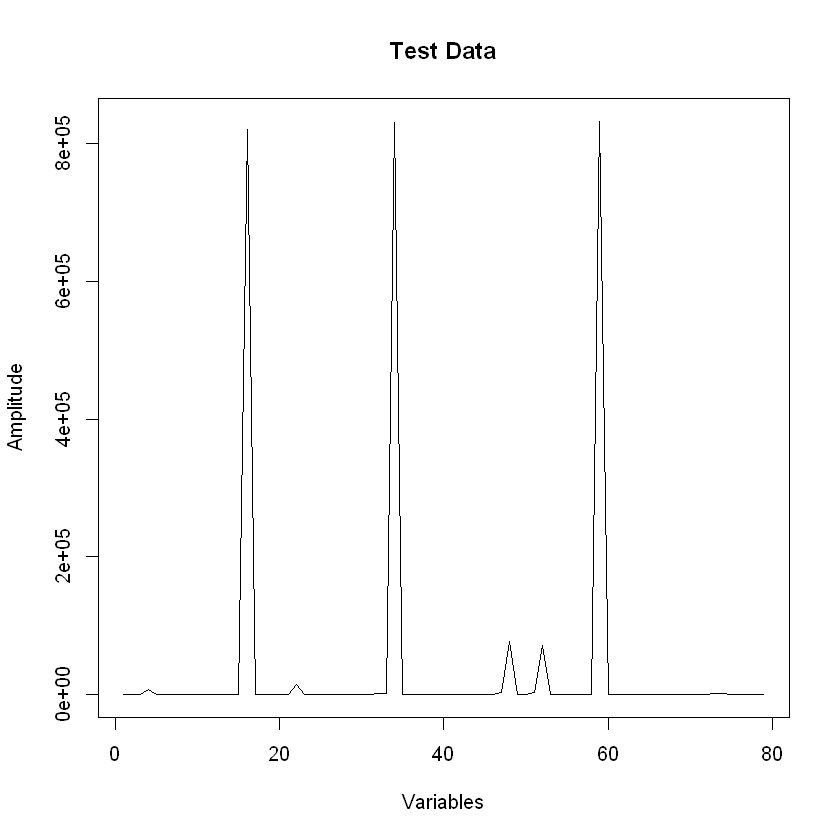

In [25]:
# Ploting mean of the generated signal   #
##########################################

mean_signal <- colMeans(oTrainData)

plot(mean_signal, type = "l", main = "Train Data", xlab = "Variables", ylab = "Amplitude")

# Ploting mean of the generated signal   #
##########################################

mean_signal <- colMeans(oTestData)

plot(mean_signal, type = "l", main = "Test Data", xlab = "Variables", ylab = "Amplitude")

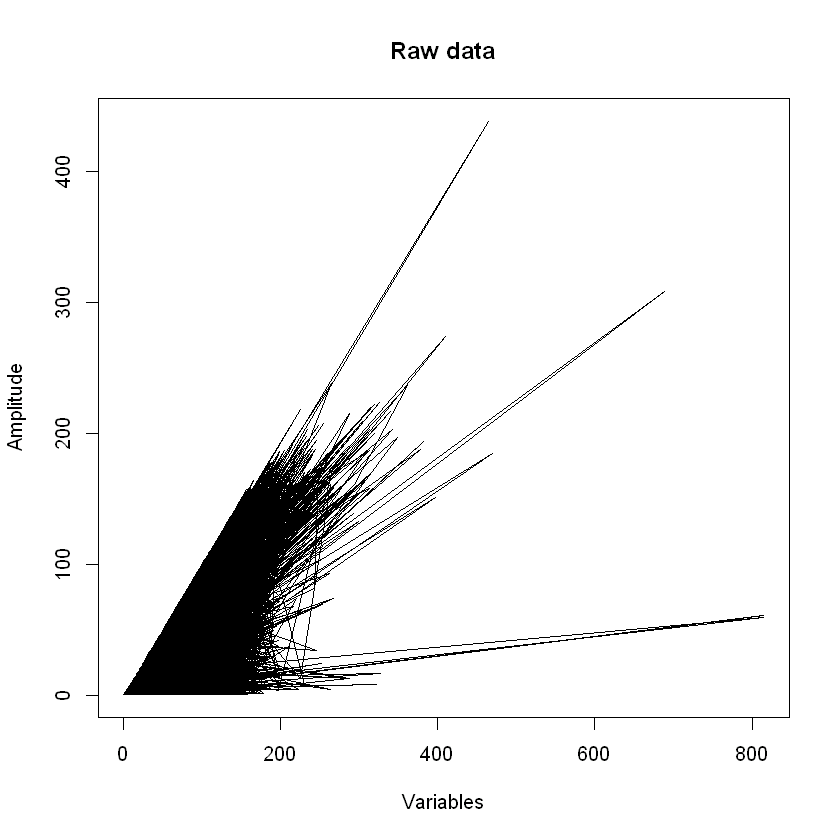

In [27]:
plot(oTrainData, type = "l", main = "Raw data", xlab = "Variables", ylab = "Amplitude")

In [29]:
Analyze_PCA <- function(X, numAxes = 50, explainedVarianceThreshold = 70) {
  pca <- prcomp(X, center = TRUE, scale. = TRUE)
  
  variance <- (pca$sdev^2 / sum(pca$sdev^2)) * 100
  cat(paste0("Variance explained by the first ", numAxes, " axes: ", sum(variance[1:numAxes]), "\n"))
  
  cum_variance <- cumsum(variance)
  
  num_components <- which(cum_variance >= explainedVarianceThreshold)[1]
  cat(paste("Number of principal components:", num_components, "to have", explainedVarianceThreshold, "% of variance\n"))
  
  d <- data.frame(PCAxes = seq_along(variance), Variance = variance, CumulativeVariance = cum_variance)

  library(ggplot2)
  p1 <- ggplot(d, aes(PCAxes, Variance)) +
    geom_col(fill = "skyblue") +
    labs(title = "Variance Explained by Each Principal Component", 
         x = "Principal Component", y = "Variance (%)") +
    theme_minimal()
  
  p2 <- ggplot(d, aes(PCAxes, CumulativeVariance)) +
    geom_line(color = "blue") +
    geom_point() +
    labs(title = "Cumulative Variance Explained", 
         x = "Principal Component", y = "Cumulative Variance (%)") +
    geom_hline(yintercept = explainedVarianceThreshold, linetype = "dashed", color = "red") +
    annotate("text", x = num_components, y = explainedVarianceThreshold + 5, 
             label = paste("Components:", num_components), color = "red") +
    theme_minimal()
  
  print(p1)
  print(p2)

  return(list(Variance = variance, CumulativeVariance = cum_variance, NumComponents = num_components))
}

[1] "Current Time : 2024-12-08 10:46:30"
Variance explained by the first 15 axes: 76.7028154710984
Number of principal components: 12 to have 70 % of variance


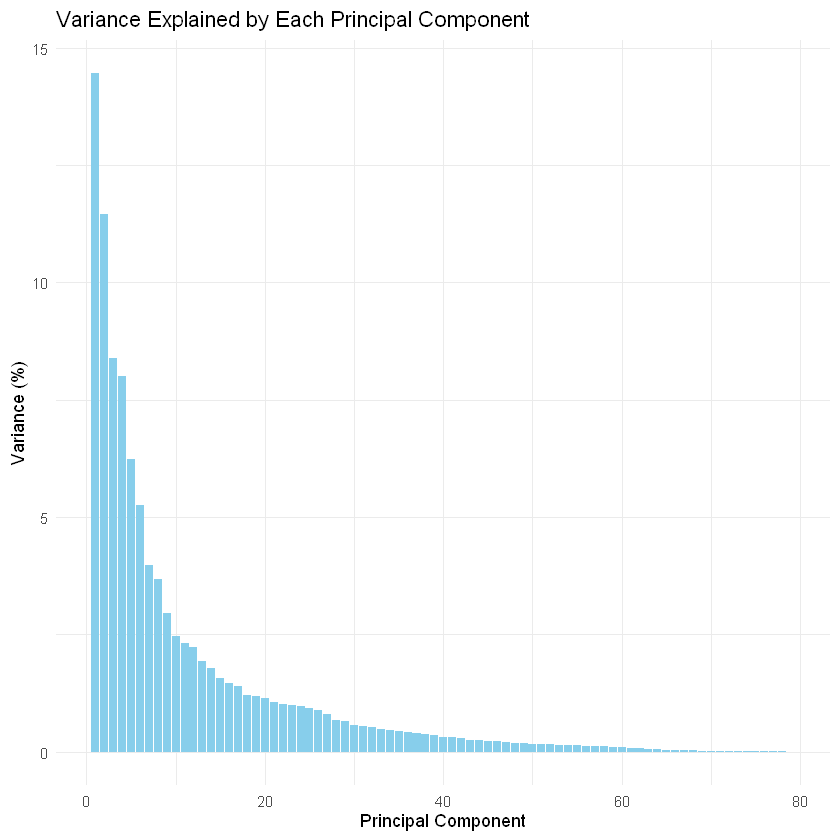

[1] "Current Time : 2024-12-08 10:46:31"
[1] "Standard PCA computation time : 1.155 seconds"


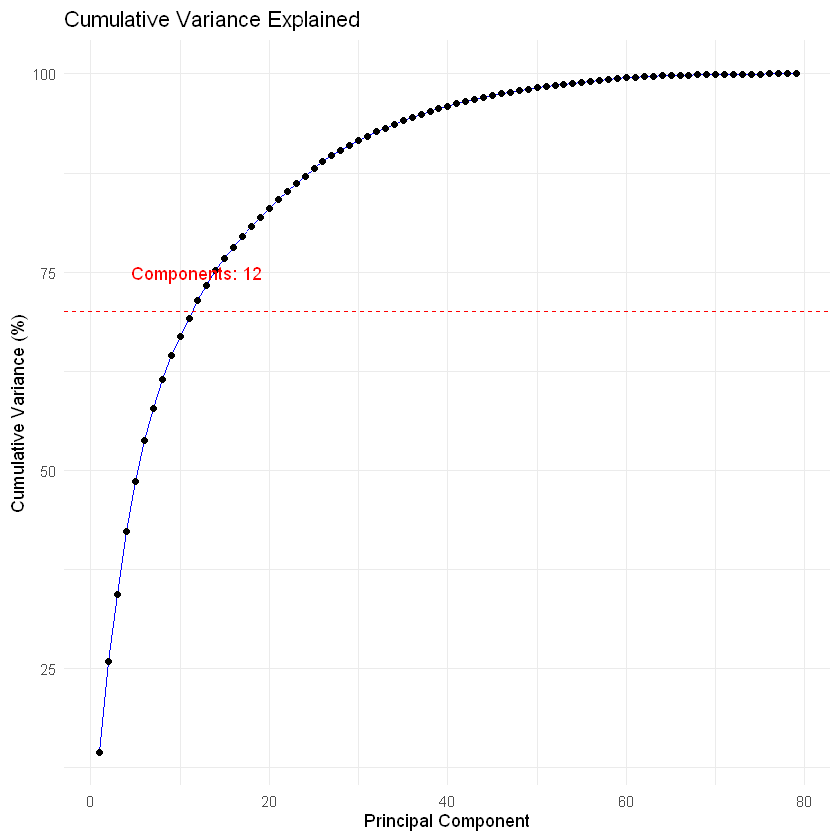

In [31]:
# PCA Exploration                        #
##########################################

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

oPCAAnalysis <- Analyze_PCA(oDataMatrix, numAxes = 15, explainedVarianceThreshold = 70)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Standard PCA computation time :", elapsed_time, "seconds"))

In [33]:
# Create the functions to compute the evaluation criteria

Get_RMSE <- function(rActual, rPredicted) {
  if (length(rActual) != length(rPredicted)) {
    stop("Get_RMSE() - Error : Vectors rActual & rPredicted must have the same lenght.")
  }
  if (any(is.na(rActual)) || any(is.na(rPredicted))) {
    stop("Get_RMSE() - Error : Input data contains NA value(s).")
  }
  return(sqrt(mean((rActual - rPredicted)^2, na.rm = TRUE)))
}

Get_MSE <- function(rActual, rPredicted) {
  if (length(rActual) != length(rPredicted)) {
    stop("Get_MSE() - Error : Vectors rActual & rPredicted must have the same lenght.")
  }
  if (any(is.na(rActual)) || any(is.na(rPredicted))) {
    stop("Get_MSE() - Error : Input data contains NA value(s).")
  }
  return(mean((rActual - rPredicted)^2, na.rm = TRUE))
}

Get_NMSE <- function(rActual, rPredicted) {
  if (length(rActual) != length(rPredicted)) {
    stop("Get_NMSE() - Error : Vectors rActual & rPredicted must have the same lenght.")
  }
  if (any(is.na(rActual)) || any(is.na(rPredicted))) {
    stop("Get_NMSE() - Error : Input data contains NA value(s).")
  }

  rMean_Squared_Error <- sum((rActual - rPredicted)^2)
  rMean_Variance_Error <- sum((rActual - mean(rActual))^2)

  if (rMean_Variance_Error == 0) {
    warning("Get_NMSE() - Error : Division / 0.")
    return(NA)
  }

  return(rMean_Squared_Error / rMean_Variance_Error)
}

# 4. Standard PCA

In [36]:
Perform_Standard_PCA <- function(trainData, testData, numComponents = NULL, varianceThreshold = NULL) {
  
  # Step 1: Select variables based on a variance threshold
  if (!is.null(varianceThreshold)) {
    colVariances <- apply(trainData, 2, var)  
    selectedCols <- colVariances > varianceThreshold
    trainData <- trainData[, selectedCols, drop = FALSE]
    testData <- testData[, selectedCols, drop = FALSE]
  } else {
    selectedCols <- rep(TRUE, ncol(trainData))
  }

  # Step 2: Define the number of components if not specified
  if (is.null(numComponents)) {
    numComponents <- ncol(trainData)
  }

  # Preprocessing: centering and scaling the training data
  X_train_scaled <- scale(trainData, center = TRUE, scale = TRUE)
  X_mean <- attr(X_train_scaled, "scaled:center")
  X_sd <- attr(X_train_scaled, "scaled:scale")

  # Perform PCA on the preprocessed data (not on the correlation matrix)
  # Since the data is already centered/scaled, set center=FALSE and scale.=FALSE in prcomp
  oPcaResult <- prcomp(X_train_scaled, center = FALSE, scale. = FALSE)

  # Visualization (optional)
  if (ncol(oPcaResult$x) >= 2) {
    plot(oPcaResult$x[, 1:2], main = "Standard PCA", xlab = "PC1", ylab = "PC2")
  }

  # Apply the same preprocessing to the test data
  X_test_scaled <- scale(testData, center = X_mean, scale = X_sd)

  # Project the test data onto the principal components
  # predict() can also be used directly, but here it's done manually:
  oTestScores <- X_test_scaled %*% oPcaResult$rotation[, 1:numComponents]

  # Reconstruct the test data
  X_test_reconstructed_scaled <- oTestScores %*% t(oPcaResult$rotation[, 1:numComponents])

  # Return to the original scale
  X_test_reconstructed <- sweep(X_test_reconstructed_scaled, 2, X_sd, "*")
  X_test_reconstructed <- sweep(X_test_reconstructed, 2, X_mean, "+")

  # Check dimensions
  if (!all(dim(X_test_reconstructed) == dim(testData))) {
    stop("Mismatch in dimensions between testData and reconstructed data")
  }

  # Evaluation
  dRMSE <- Get_RMSE(as.vector(testData), as.vector(X_test_reconstructed))
  dMSE <- Get_MSE(as.vector(testData), as.vector(X_test_reconstructed))
  dNMSE <- Get_NMSE(as.vector(testData), as.vector(X_test_reconstructed))

  result <- list(RMSE = dRMSE, MSE = dMSE, NMSE = dNMSE)
  if (!is.null(varianceThreshold)) {
    result$ActiveVariables <- sum(selectedCols)
  } else {
    result$ActiveVariables <- numComponents
  }

  return(result)
}

[1] "Current Time : 2024-12-08 10:46:38"
[1] "Number of Components: 18"
[1] "Standard PCA - RMSE: 3310.59381667714"
[1] "Standard PCA - MSE: 10960031.4190209"
[1] "Standard PCA - NMSE: 0.000436977918762469"
[1] "Current Time : 2024-12-08 10:46:40"
[1] "Standard PCA computation time : 1.441 seconds"


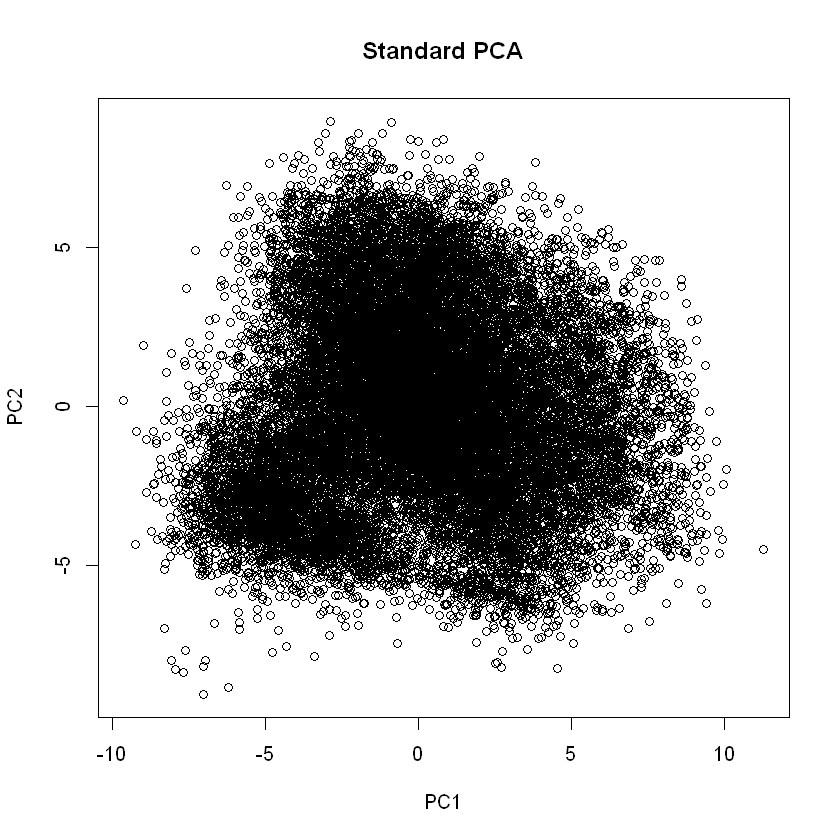

In [38]:
# Standard PCA on the Train DATASET      #
##########################################

# Cell execution time 15/11/2024 : 1.929 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# First step => Find the number of components explaining 95% of the variance
oPCAResult <- prcomp(oTrainData, center = TRUE, scale. = TRUE)
dExplained_Variance <- cumsum(oPCAResult$sdev^2) / sum(oPCAResult$sdev^2)
iNumComponents <- which(dExplained_Variance >= 0.80)[1]
print(paste("Number of Components:", iNumComponents))

# Perform Standard PCA
oStandardPCAResults <- Perform_Standard_PCA(oTrainData, oTestData, numComponents = iNumComponents, NULL)

print(paste("Standard PCA - RMSE:", oStandardPCAResults$RMSE))
print(paste("Standard PCA - MSE:", oStandardPCAResults$MSE))
print(paste("Standard PCA - NMSE:", oStandardPCAResults$NMSE))

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Standard PCA computation time :", elapsed_time, "seconds"))

# 5. PCA based on Variance Selection

[1] "Current Time : 2024-12-08 10:46:59"


$RMSE
[1] 2480.208

$MSE
[1] 6151432

$NMSE
[1] 0.0001771578

$ActiveVariables
[1] 56

[1] "Current Time : 2024-12-08 10:46:59"
[1] "Variance Selection PCA computation time : 0.669 seconds"


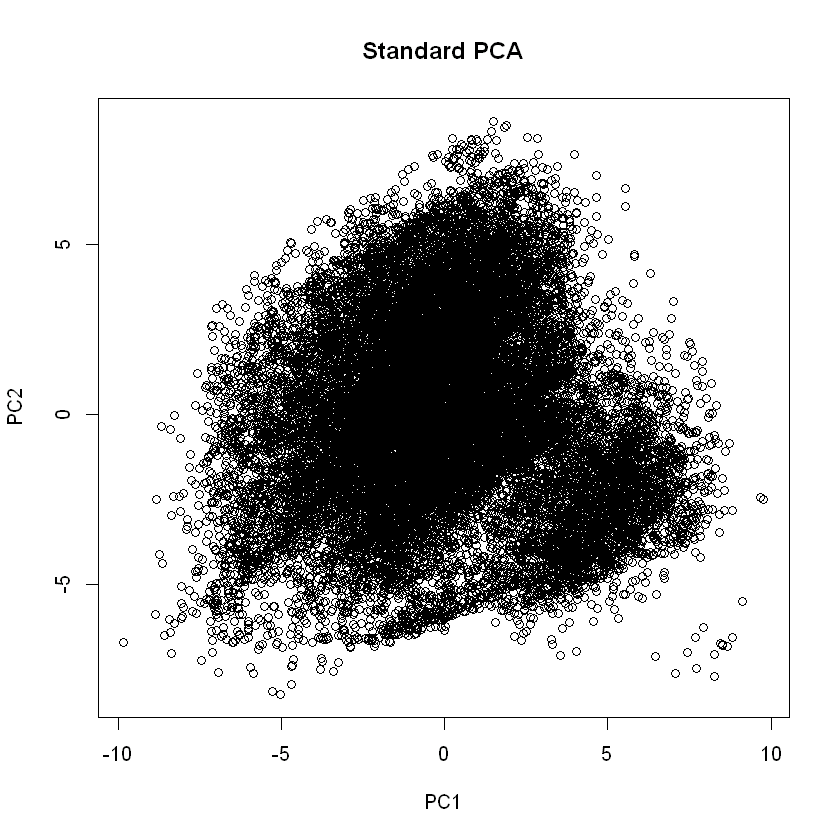

In [41]:
# Variance Selection PCA on the Train DATASET      #
####################################################

# Cell execution time 15/11/2024 : 1.929 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# Perform Variance Selection PCA
oVarPCAResults <- Perform_Standard_PCA(oTrainData, oTestData, numComponents = iNumComponents, varianceThreshold = 1)

oVarPCAResults

# Display end time and elapsed time
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Variance Selection PCA computation time :", elapsed_time, "seconds"))

# 6. Sparse PCA

In [44]:
Perform_Sparse_PCA <- function(trainData, testData, paraValues, numComponents = 1) {
  library(elasticnet)
  
  # Data frame to store numeric results
  results <- data.frame(Para = paraValues, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = NA)
  
  # List to store loadings for each para value
  loadings_list <- list()
  
  # Parallel execution
  parallel_results <- foreach(i = 1:length(paraValues), .combine = rbind,
                              .packages = c("elasticnet"), 
                              .export = c("Get_RMSE", "Get_MSE", "Get_NMSE")) %dopar% {
    iPara <- paraValues[i]

    # HERE THE CALL WITH PRE-TREATMENT. Cor Matrix Sended to the fonction.
    # Preprocessing: scale trainData and compute covariance matrix
    X <- scale(trainData, center = TRUE, scale = TRUE)
    S <- cor(X)  # Matrice de corrélation
    # Perform Sparse PCA using the covariance matrix and type = "Gram"
    oSparsePcaResult <- spca(S, K = numComponents, sparse = "penalty", para = rep(iPara, numComponents), type = "Gram")

    # HERE THE CALL WITH RAW DATA      
    # oSparsePcaResult <- spca(trainData, K = numComponents, sparse = "penalty", para = rep(iPara, numComponents))

      
    if (!is.null(oSparsePcaResult$loadings)) {
      # Scale testData with the same parameters used for trainData
      testDataScaled <- scale(testData, 
                              center = attr(X, "scaled:center"), 
                              scale = attr(X, "scaled:scale"))
      
      # Compute scores for test data in scaled space
      oTestScores <- testDataScaled %*% oSparsePcaResult$loadings
      
      # Reconstruct scaled test data
      oReconstructedScaled <- oTestScores %*% t(oSparsePcaResult$loadings)
      
      # Unscale the reconstructed data to original scale
      # First multiply by scale, then add center back
      oReconstructedData <- sweep(oReconstructedScaled, 2, attr(X, "scaled:scale"), "*")
      oReconstructedData <- sweep(oReconstructedData, 2, attr(X, "scaled:center"), "+")

      # Evaluate metrics using the original testData scale
      dRMSE <- Get_RMSE(as.vector(testData), as.vector(oReconstructedData))
      dMSE <- Get_MSE(as.vector(testData), as.vector(oReconstructedData))
      dNMSE <- Get_NMSE(as.vector(testData), as.vector(oReconstructedData))
      
      # Count non-zero loadings
      non_zero_loadings <- sum(oSparsePcaResult$loadings != 0)
      
      cat("Para =", iPara, "- RMSE:", dRMSE, "- MSE:", dMSE, "- NMSE:", dNMSE, "- Non-zero loadings:", non_zero_loadings, "\n")
      
      # Return iteration results
      data.frame(Para = iPara, RMSE = dRMSE, MSE = dMSE, NMSE = dNMSE, ActiveVariables = non_zero_loadings)
    } else {
      cat("Para =", iPara, "- No valid loadings returned by spca\n")
      data.frame(Para = iPara, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = NA)
    }
  }
  
  # After parallel execution, we need to retrieve loadings in sequential mode.
  # If you want consistent results, use the same approach (covariance matrix + type = "Gram") here as well.
  X <- scale(trainData, center = TRUE, scale = TRUE)
  S <- cov(X)
  for (iPara in paraValues) {
    oSparsePcaResult <- spca(S, K = numComponents, sparse = "penalty", para = rep(iPara, numComponents), type = "Gram")
    if (!is.null(oSparsePcaResult$loadings)) {
      loadings_list[[as.character(iPara)]] <- oSparsePcaResult$loadings
    } else {
      loadings_list[[as.character(iPara)]] <- NULL
    }
  }
  
  results <- parallel_results
  
  # Return a list containing the results data frame and the loadings list
  return(list(results = results, loadings = loadings_list))
}

In [46]:
##########################################
# Sparse PCA on the entire Train DATASET #
##########################################

# Cell execution time 15/11/2024 : 355.319 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# Penalty list
oParaValues <- c(1, 2, 3, 5, 10, 15, 20, 25, 30)

# Perform Sparse PCA
res <- Perform_Sparse_PCA(oTrainData, oTestData, oParaValues, numComponents = 1)

oSparsePCAResults <- res$results
loadings_list <- res$loadings


print(oSparsePCAResults[, -6])

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Sparse PCA computation time :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-08 10:47:05"
  Para     RMSE      MSE        NMSE ActiveVariables
1    1 7003.961 49055469 0.001955848              12
2    2 7013.661 49191445 0.001961269               8
3    3 7013.662 49191448 0.001961270               7
4    5 7013.662 49191450 0.001961270               1
5   10 7013.662 49191453 0.001961270               0
6   15 7013.662 49191453 0.001961270               0
7   20 7013.662 49191453 0.001961270               0
8   25 7013.662 49191453 0.001961270               0
9   30 7013.662 49191453 0.001961270               0
[1] "Current Time : 2024-12-08 10:47:08"
[1] "Sparse PCA computation time : 2.615 seconds"


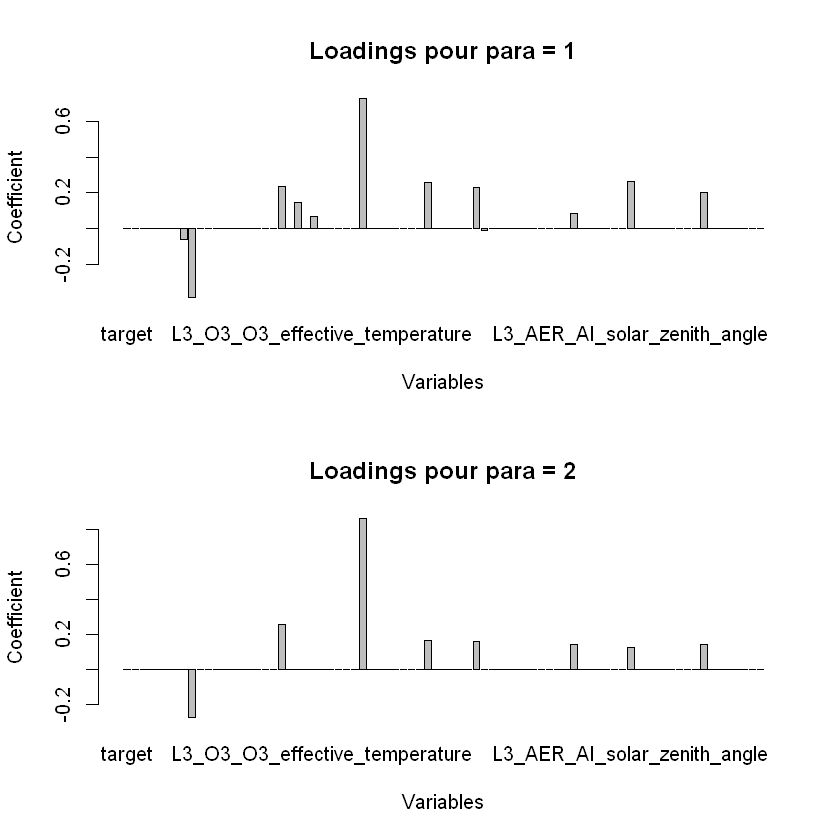

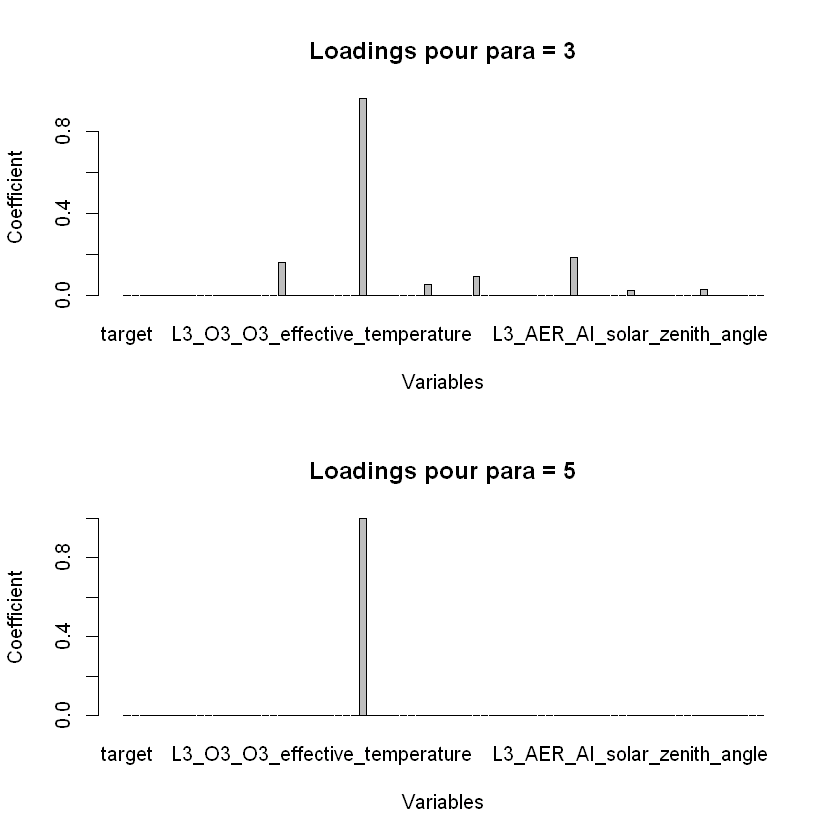

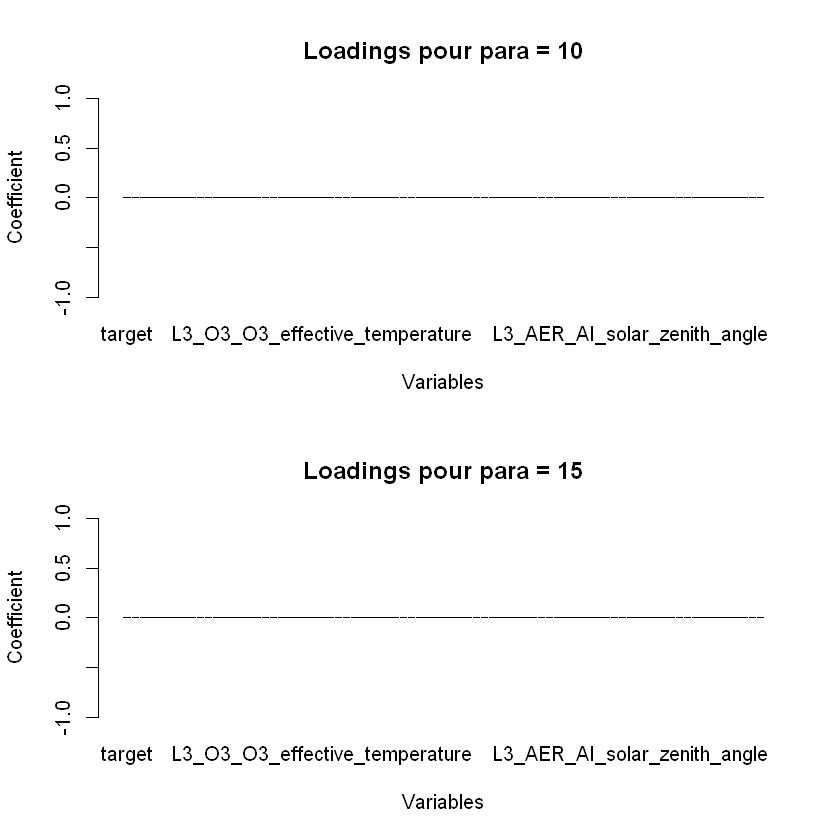

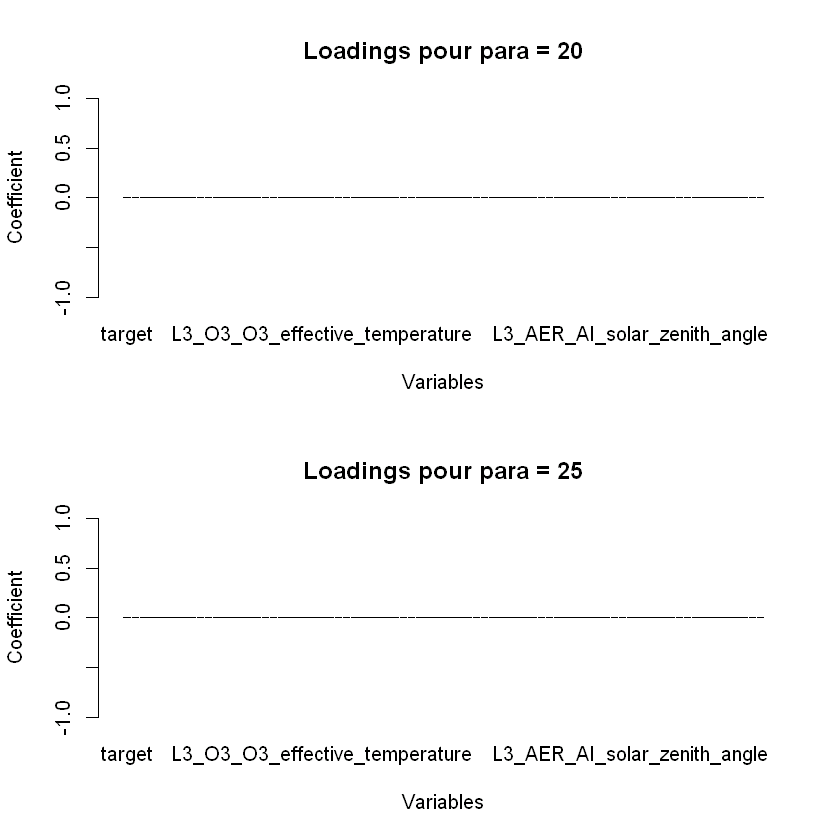

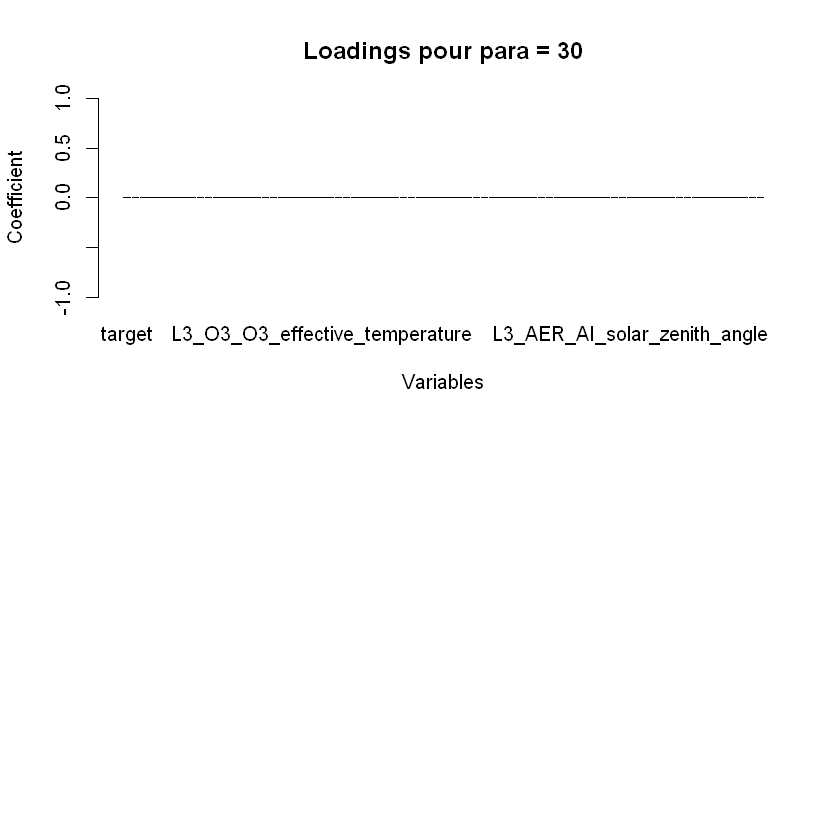

In [48]:
##########################################
# Sparse PCA Loadings Visual             #
##########################################

par(mfrow = c(ceiling(length(oParaValues)/6), 1))

for (iPara in oParaValues) {
  loadings <- loadings_list[[as.character(iPara)]]
  
  if (!is.null(loadings)) {
    barplot(loadings[, 1], main = paste("Loadings pour para =", iPara),
            xlab = "Variables", ylab = "Coefficient")
  } else {
    plot.new()
    title(main = paste("Pas de loadings pour para =", iPara))
  }
}

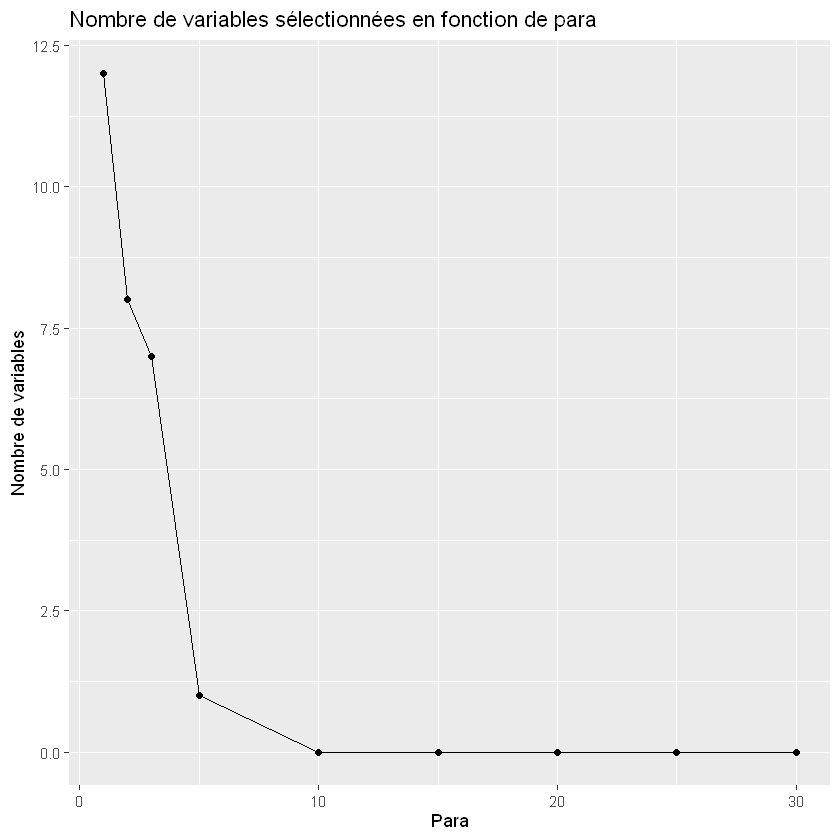

In [50]:
ggplot(oSparsePCAResults, aes(x = Para, y = ActiveVariables)) +
  geom_point() +
  geom_line() +
  labs(title = "Nombre de variables sélectionnées en fonction de para", x = "Para", y = "Nombre de variables")

In [52]:
# Sparse PCA : Showing the best result  #
#########################################

# Cell execution time 15/11/2024 : 355.319 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

library(elasticnet)

variances <- apply(oTrainData, 2, var)

k <- 60 # Varaiables to keep
top_var_indices <- order(variances, decreasing = TRUE)[1:k]
x_reduced <- oTrainData[, top_var_indices]  # Jeu de données réduit

pca_sparse <- prcomp(x_reduced, center = TRUE, scale. = TRUE)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Sparse PCA computation time :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-08 10:47:23"
[1] "Current Time : 2024-12-08 10:47:23"
[1] "Sparse PCA computation time : 0.224 seconds"


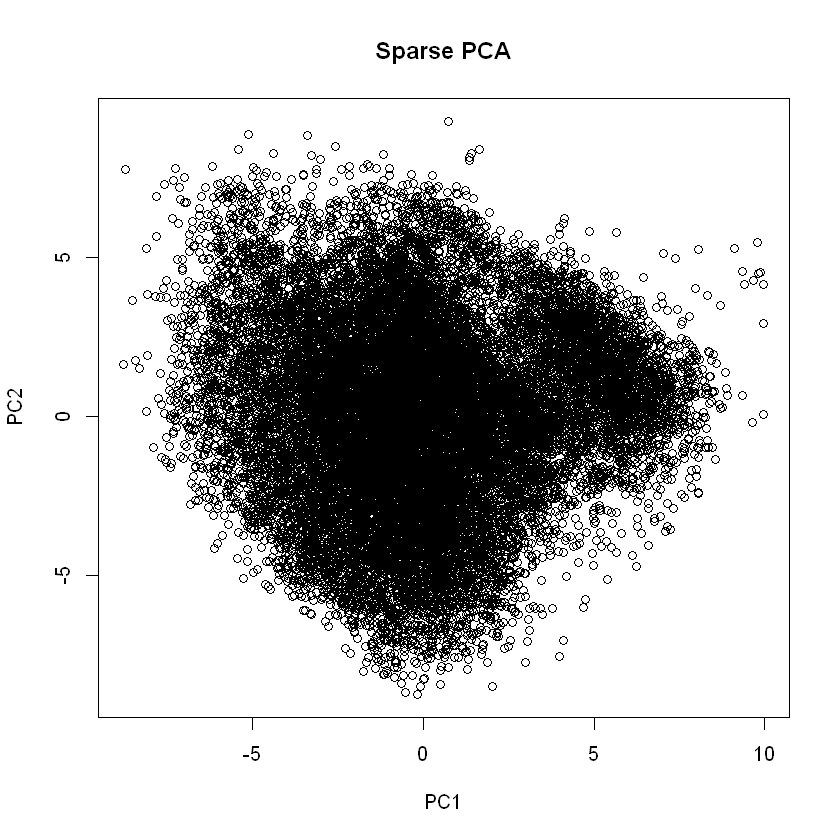

In [54]:
plot(pca_sparse$x[, 1:2], main = "Sparse PCA",
     xlab = "PC1", ylab = "PC2")

# THRESHOLD PCA

In [57]:
Perform_Threshold_PCA <- function(trainData, testData, thresholdValues, numComponents = 1) {
  results <- data.frame(Threshold = thresholdValues, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = NA)
  
  # Parallel execution with exported functions
  results <- foreach(i = 1:length(thresholdValues), .combine = rbind, 
                     .packages = c("stats"), 
                     .export = c("Get_RMSE", "Get_MSE", "Get_NMSE")) %dopar% {
    dThreshold <- thresholdValues[i]
    
    # Selecting variables with variance above the threshold
    oVariances <- apply(trainData, 2, var)
    oSelectedIndices <- which(oVariances > dThreshold)
    ActiveVariables <- length(oSelectedIndices)
    
    if (ActiveVariables > 0) {
      # Subset of selected variables
      oTrainDataSelected <- trainData[, oSelectedIndices, drop = FALSE]
      oTestDataSelected <- testData[, oSelectedIndices, drop = FALSE]

      # Centering and scaling on the selected training data
      X_train_selected_scaled <- scale(oTrainDataSelected, center = TRUE, scale = TRUE)
      X_mean <- attr(X_train_selected_scaled, "scaled:center")
      X_sd <- attr(X_train_selected_scaled, "scaled:scale")

      # PCA on the preprocessed selected data
      # Set center=FALSE, scale.=FALSE since centering/scaling is done manually
      oPcaResult <- prcomp(X_train_selected_scaled, center = FALSE, scale. = FALSE)

      # Apply the same preprocessing to the selected test data
      X_test_selected_scaled <- scale(oTestDataSelected, center = X_mean, scale = X_sd)
      
      # Project test data onto principal components
      oTestScores <- X_test_selected_scaled %*% oPcaResult$rotation[, 1:min(numComponents, ActiveVariables), drop = FALSE]

      # Reconstruct in scaled form
      X_test_reconstructed_selected_scaled <- oTestScores %*% t(oPcaResult$rotation[, 1:min(numComponents, ActiveVariables), drop = FALSE])

      # Return to the original scale for the selected subset
      X_test_reconstructed_selected <- sweep(X_test_reconstructed_selected_scaled, 2, X_sd, "*")
      X_test_reconstructed_selected <- sweep(X_test_reconstructed_selected, 2, X_mean, "+")

      # Place the reconstructed subset back into the full matrix (non-selected variables = 0)
      oReconstructedFull <- matrix(0, nrow = nrow(testData), ncol = ncol(testData))
      oReconstructedFull[, oSelectedIndices] <- X_test_reconstructed_selected

      # Evaluation
      dRMSE <- Get_RMSE(as.vector(testData), as.vector(oReconstructedFull))
      dMSE <- Get_MSE(as.vector(testData), as.vector(oReconstructedFull))
      dNMSE <- Get_NMSE(as.vector(testData), as.vector(oReconstructedFull))
      
      # Store results
      result_row <- data.frame(Threshold = dThreshold, RMSE = dRMSE, MSE = dMSE, NMSE = dNMSE, ActiveVariables = ActiveVariables)
      
      cat("Threshold =", dThreshold, "- RMSE:", dRMSE, "- MSE:", dMSE, "- NMSE:", dNMSE, "- Num Variables:", ActiveVariables, "\n")
    } else {
      cat("Threshold =", dThreshold, "- No variables selected\n")
      result_row <- data.frame(Threshold = dThreshold, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = 0)
    }
    
    result_row
  }
  
  return(results)
}

In [59]:
# Threshold PCA on the entire DATASET 01   #
############################################

# Cell execution time 15/11/2024 : 13.563 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# Threshold list
thresholdValues <- seq(0.05, 1.5, by = 0.05)

# Perform Threshold PCA
oThresholdPCAResults <- Perform_Threshold_PCA(oTrainData, oTestData, thresholdValues, numComponents = 1)

print(oThresholdPCAResults)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Threshold PCA computation time :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-08 10:47:32"
   Threshold     RMSE      MSE        NMSE ActiveVariables
1       0.05 6991.938 48887200 0.001949139              63
2       0.10 6991.529 48881482 0.001948911              61
3       0.15 6987.767 48828886 0.001946814              59
4       0.20 6987.767 48828886 0.001946814              59
5       0.25 6985.868 48802349 0.001945756              58
6       0.30 6984.187 48778872 0.001944820              57
7       0.35 6983.551 48769989 0.001944466              56
8       0.40 6983.551 48769989 0.001944466              56
9       0.45 6983.551 48769989 0.001944466              56
10      0.50 6983.551 48769989 0.001944466              56
11      0.55 6983.551 48769989 0.001944466              56
12      0.60 6983.551 48769989 0.001944466              56
13      0.65 6983.551 48769989 0.001944466              56
14      0.70 6983.551 48769989 0.001944466              56
15      0.75 6983.551 48769989 0.001944466              56
16      0.80 69

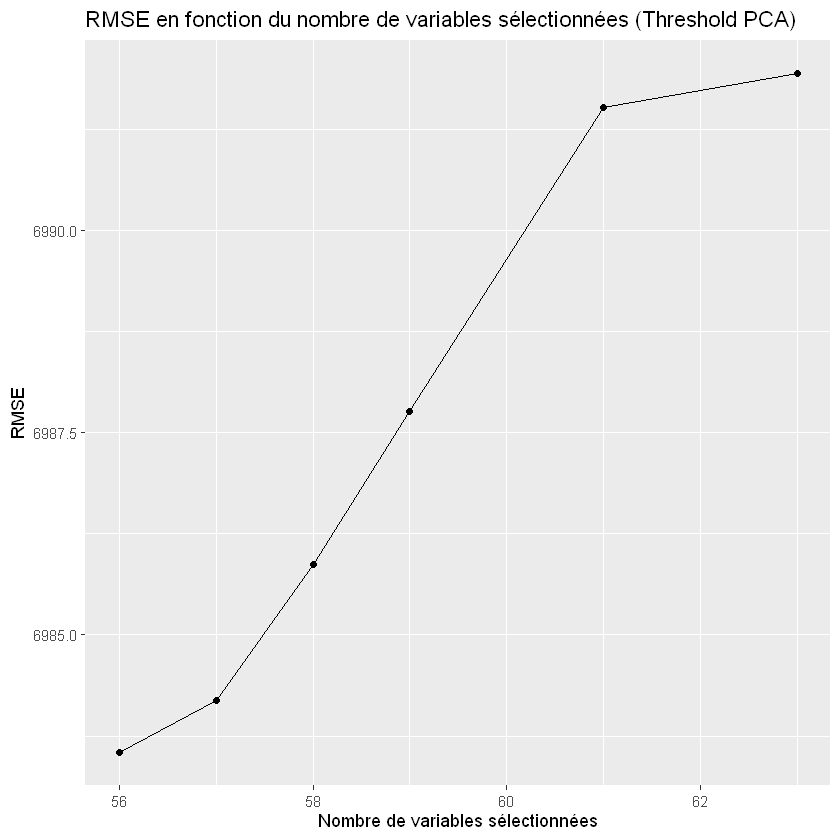

In [61]:
ggplot(oThresholdPCAResults, aes(x = ActiveVariables, y = RMSE)) +
  geom_point() +
  geom_line() +
  labs(title = "RMSE en fonction du nombre de variables sélectionnées (Threshold PCA)",
       x = "Nombre de variables sélectionnées", y = "RMSE")

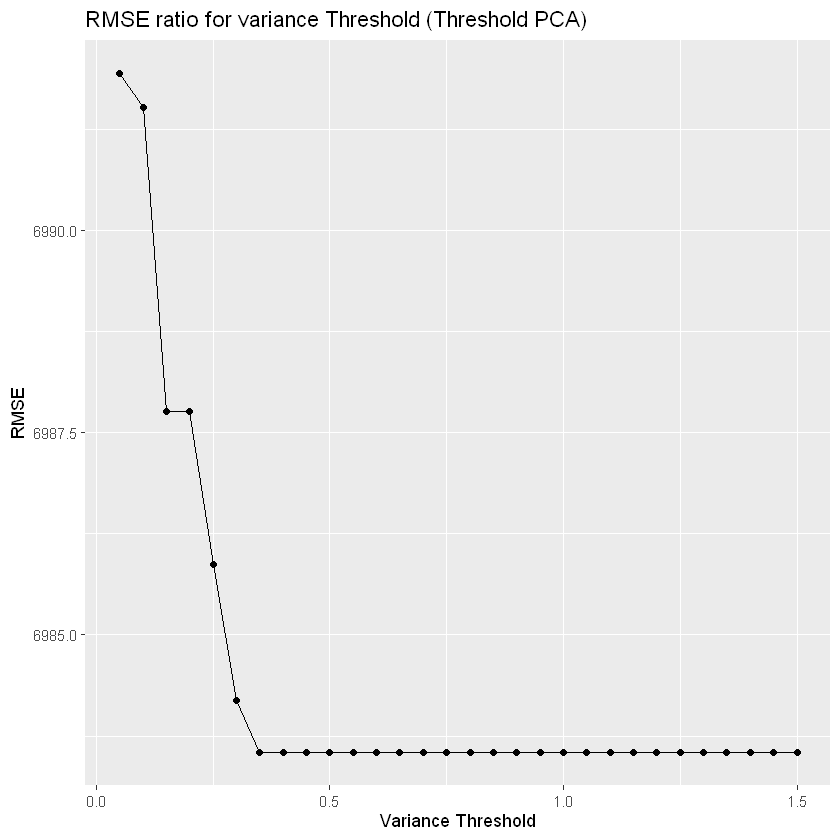

In [63]:
ggplot(oThresholdPCAResults, aes(x = Threshold, y = RMSE)) +
  geom_point() +
  geom_line() +
  labs(title = "RMSE ratio for variance Threshold (Threshold PCA)",
       x = "Variance Threshold", y = "RMSE")

# 7. RESULTS

In [86]:
# Merging results array                 #
#########################################

library(reshape2)
library(tidyr)

# Convert named lists to numeric values
oStandardPCAResults$RMSE <- as.numeric(oStandardPCAResults$RMSE)
oStandardPCAResults$MSE <- as.numeric(oStandardPCAResults$MSE)
oStandardPCAResults$NMSE <- as.numeric(oStandardPCAResults$NMSE)
oVarPCAResults$RMSE <- as.numeric(oVarPCAResults$RMSE)
oVarPCAResults$MSE <- as.numeric(oVarPCAResults$MSE)
oVarPCAResults$NMSE <- as.numeric(oVarPCAResults$NMSE)
oSparsePCAResults$RMSE <- sapply(oSparsePCAResults$RMSE, as.numeric)
oSparsePCAResults$MSE <- sapply(oSparsePCAResults$MSE, as.numeric)
oSparsePCAResults$NMSE <- sapply(oSparsePCAResults$NMSE, as.numeric)
oThresholdPCAResults$RMSE <- sapply(oThresholdPCAResults$RMSE, as.numeric)
oThresholdPCAResults$MSE <- sapply(oThresholdPCAResults$MSE, as.numeric)
oThresholdPCAResults$NMSE <- sapply(oThresholdPCAResults$NMSE, as.numeric)

# New data frames
standardPCAResultsDF <- data.frame(Method = "Standard PCA", Parameter = 0, 
                                   RMSE = round(oStandardPCAResults$RMSE, 4), 
                                   MSE = round(oStandardPCAResults$MSE, 4), 
                                   NMSE = round(oStandardPCAResults$NMSE, 4),
                                   ActiveVariables = unlist(oStandardPCAResults$ActiveVariables))

variancePCAResultsDF <- data.frame(Method = "Variance PCA", Parameter = 0, 
                                   RMSE = round(oVarPCAResults$RMSE, 4), 
                                   MSE = round(oVarPCAResults$MSE, 4), 
                                   NMSE = round(oVarPCAResults$NMSE, 4),
                                   ActiveVariables = unlist(oVarPCAResults$ActiveVariables))

sparsePCAResultsDF <- data.frame(Method = "Sparse PCA", Parameter = oSparsePCAResults$Para, 
                                 RMSE = round(unlist(oSparsePCAResults$RMSE), 4), 
                                 MSE = round(unlist(oSparsePCAResults$MSE), 4), 
                                 NMSE = round(unlist(oSparsePCAResults$NMSE), 4),
                                 ActiveVariables = unlist(oSparsePCAResults$ActiveVariables))

thresholdPCAResultsDF <- data.frame(Method = "Threshold PCA", Parameter = oThresholdPCAResults$Threshold, 
                                    RMSE = round(unlist(oThresholdPCAResults$RMSE), 4), 
                                    MSE = round(unlist(oThresholdPCAResults$MSE), 4), 
                                    NMSE = round(unlist(oThresholdPCAResults$NMSE), 4),
                                    ActiveVariables = unlist(oThresholdPCAResults$ActiveVariables))                                    

# Combine all results
allResults <- rbind(standardPCAResultsDF, variancePCAResultsDF, sparsePCAResultsDF, thresholdPCAResultsDF)

# Cleaning
allResults$Parameter <- replace_na(allResults$Parameter, 0)

# Calculate Global_Score with rounded values
allResults <- allResults %>%
  mutate(Global_Score = round((RMSE + MSE + NMSE) / 3, 4))

print(allResults)

          Method Parameter     RMSE      MSE   NMSE ActiveVariables
1   Standard PCA      0.00 3310.594 10960031 0.0004              18
2   Variance PCA      0.00 2480.208  6151432 0.0002              56
3     Sparse PCA      1.00 7003.961 49055469 0.0020              12
4     Sparse PCA      2.00 7013.661 49191445 0.0020               8
5     Sparse PCA      3.00 7013.662 49191448 0.0020               7
6     Sparse PCA      5.00 7013.662 49191450 0.0020               1
7     Sparse PCA     10.00 7013.662 49191453 0.0020               0
8     Sparse PCA     15.00 7013.662 49191453 0.0020               0
9     Sparse PCA     20.00 7013.662 49191453 0.0020               0
10    Sparse PCA     25.00 7013.662 49191453 0.0020               0
11    Sparse PCA     30.00 7013.662 49191453 0.0020               0
12 Threshold PCA      0.05 6991.938 48887200 0.0019              63
13 Threshold PCA      0.10 6991.529 48881482 0.0019              61
14 Threshold PCA      0.15 6987.767 48828886 0.0

In [68]:
library(dplyr)
library(ggplot2)

# Trier allResults sur le NMSE
sortedResults <- allResults %>%
  arrange(NMSE)  # Classement par NMSE croissant

# Afficher le tableau trié
print(sortedResults)

# Identifier la méthode gagnante (celle avec le NMSE le plus bas)
bestMethod <- sortedResults %>%
  slice(1)  # Première ligne correspond au plus petit NMSE

cat("The best method is:", bestMethod$Method, "with a NMSE of", bestMethod$NMSE, "\n")

          Method Parameter     RMSE      MSE   NMSE Global_Score
1   Variance PCA      0.00 2480.208  6151432 0.0002      2051304
2   Standard PCA      0.00 3310.594 10960031 0.0004      3654447
3  Threshold PCA      0.05 6991.938 48887200 0.0019     16298064
4  Threshold PCA      0.10 6991.529 48881482 0.0019     16296158
5  Threshold PCA      0.15 6987.767 48828886 0.0019     16278624
6  Threshold PCA      0.20 6987.767 48828886 0.0019     16278624
7  Threshold PCA      0.25 6985.868 48802349 0.0019     16269778
8  Threshold PCA      0.30 6984.187 48778872 0.0019     16261952
9  Threshold PCA      0.35 6983.551 48769989 0.0019     16258991
10 Threshold PCA      0.40 6983.551 48769989 0.0019     16258991
11 Threshold PCA      0.45 6983.551 48769989 0.0019     16258991
12 Threshold PCA      0.50 6983.551 48769989 0.0019     16258991
13 Threshold PCA      0.55 6983.551 48769989 0.0019     16258991
14 Threshold PCA      0.60 6983.551 48769989 0.0019     16258991
15 Threshold PCA      0.6

# A tibble: 4 × 6
  Method        Parameter  RMSE       MSE   NMSE Global_Score
  <chr>             <dbl> <dbl>     <dbl>  <dbl>        <dbl>
1 Sparse PCA         1    7004. 49055469. 0.002     16354158.
2 Standard PCA       0    3311. 10960031. 0.0004     3654447.
3 Threshold PCA      0.05 6992. 48887200. 0.0019    16298064.
4 Variance PCA       0    2480.  6151432. 0.0002     2051304.


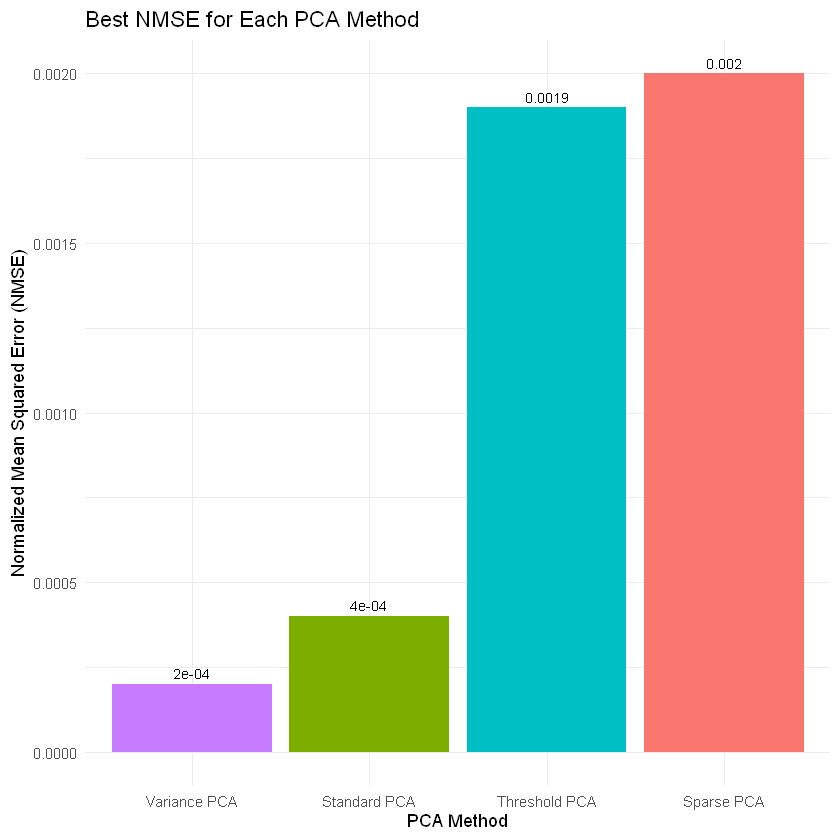

In [70]:
bestResults <- allResults %>%
  group_by(Method) %>%
  filter(NMSE == min(NMSE, na.rm = TRUE)) %>%
  slice(1) %>%
  ungroup()

print(bestResults)

ggplot(bestResults, aes(x = reorder(Method, NMSE), y = NMSE, fill = Method)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Best NMSE for Each PCA Method",
    x = "PCA Method",
    y = "Normalized Mean Squared Error (NMSE)"
  ) +
  theme_minimal() +
  theme(legend.position = "none") +
  geom_text(aes(label = round(NMSE, 4)), vjust = -0.5, size = 3)

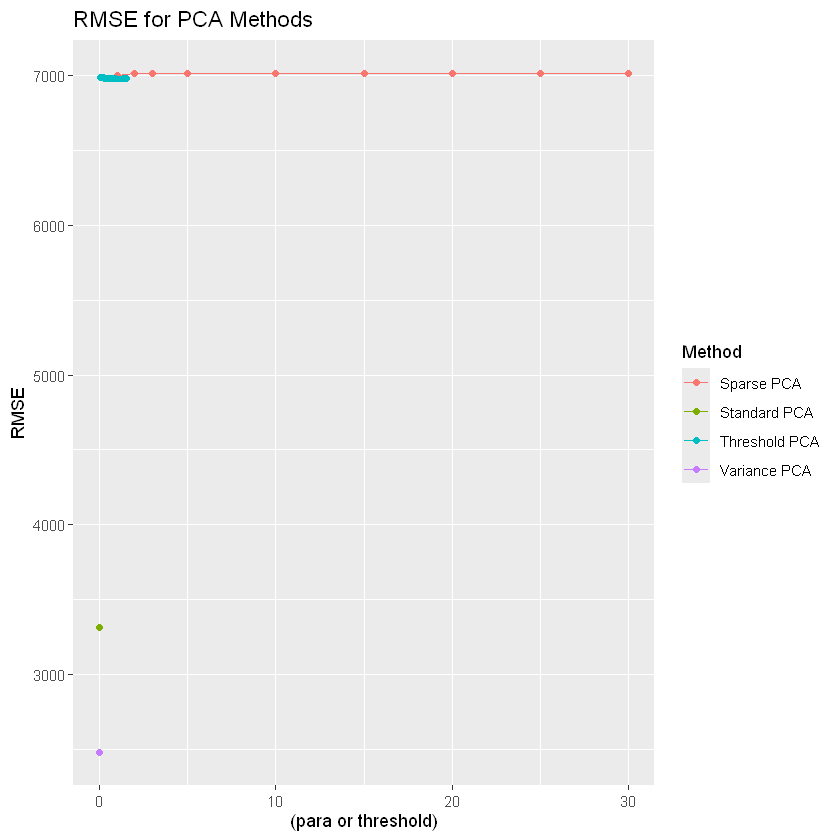

In [72]:
ggplot(allResults, aes(x = Parameter, y = RMSE, color = Method)) +
  geom_point() +
  geom_line() +
  labs(title = "RMSE for PCA Methods", x = "(para or threshold)", y = "RMSE")

In [74]:
# Computing a score                     #
#########################################

summaryDF <- allResults %>%
  group_by(Method) %>%
  summarise(
    Mean_RMSE = mean(RMSE),
    Mean_MSE = mean(MSE),
    Mean_NMSE = mean(NMSE)
  )

summaryDF <- summaryDF %>%
  mutate(Global_Score = (Mean_RMSE + Mean_MSE + Mean_NMSE) / 3)

print(summaryDF %>% arrange(Global_Score))  # Sorted by best global score...

# A tibble: 4 × 5
  Method        Mean_RMSE  Mean_MSE Mean_NMSE Global_Score
  <chr>             <dbl>     <dbl>     <dbl>        <dbl>
1 Variance PCA      2480.  6151432.    0.0002     2051304.
2 Standard PCA      3311. 10960031.    0.0004     3654447.
3 Threshold PCA     6984. 48782914.    0.0019    16263300.
4 Sparse PCA        7013. 49176342.    0.002     16394451.


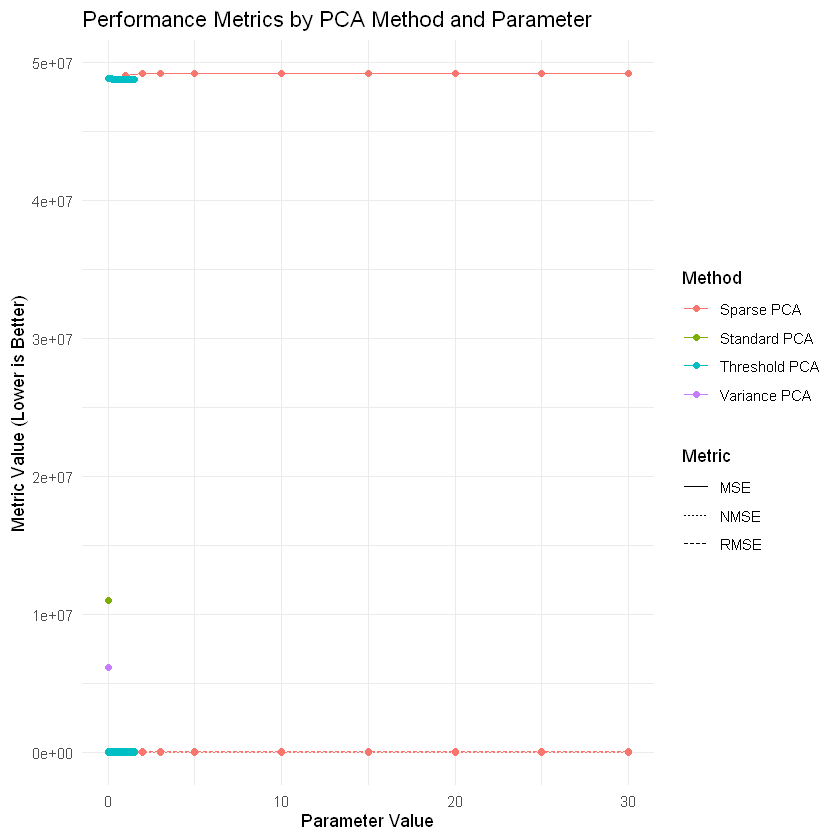

In [76]:
library(tidyr)

allResultsLong <- allResults %>%
  pivot_longer(cols = c("RMSE", "MSE", "NMSE"), names_to = "Metric", values_to = "Value")

ggplot(allResultsLong, aes(x = Parameter, y = Value, color = Method)) +
  geom_line(aes(linetype = Metric)) +
  geom_point() +
  labs(title = "Performance Metrics by PCA Method and Parameter",
       x = "Parameter Value",
       y = "Metric Value (Lower is Better)") +
  theme_minimal()

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


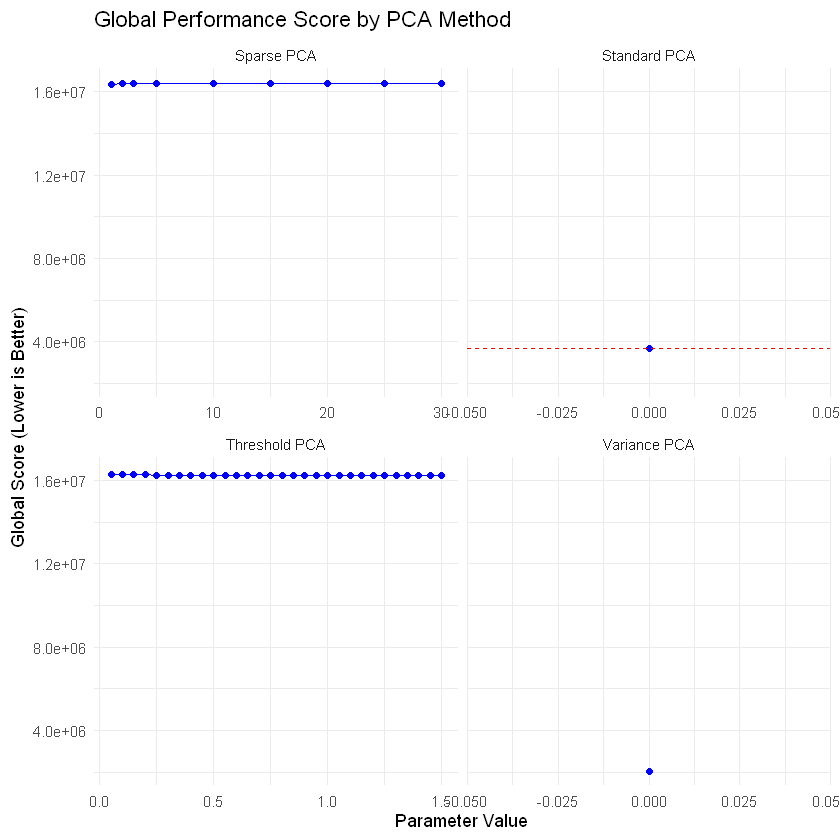

In [78]:
library(dplyr)
library(ggplot2)

# Compute vertical scale
global_min <- min(allResults$Global_Score, na.rm = TRUE)
global_max <- max(allResults$Global_Score, na.rm = TRUE)

ggplot(allResults, aes(x = Parameter, y = Global_Score)) +
  geom_line(aes(group = Method), color = "blue") +
  geom_point(color = "blue") +
  geom_hline(data = allResults %>% filter(Method == "Standard PCA"),
             aes(yintercept = Global_Score), linetype = "dashed", color = "red") +
  facet_wrap(~ Method, scales = "free_x") +
  labs(title = "Global Performance Score by PCA Method",
       x = "Parameter Value",
       y = "Global Score (Lower is Better)") +
  theme_minimal() +
  coord_cartesian(ylim = c(global_min, global_max))


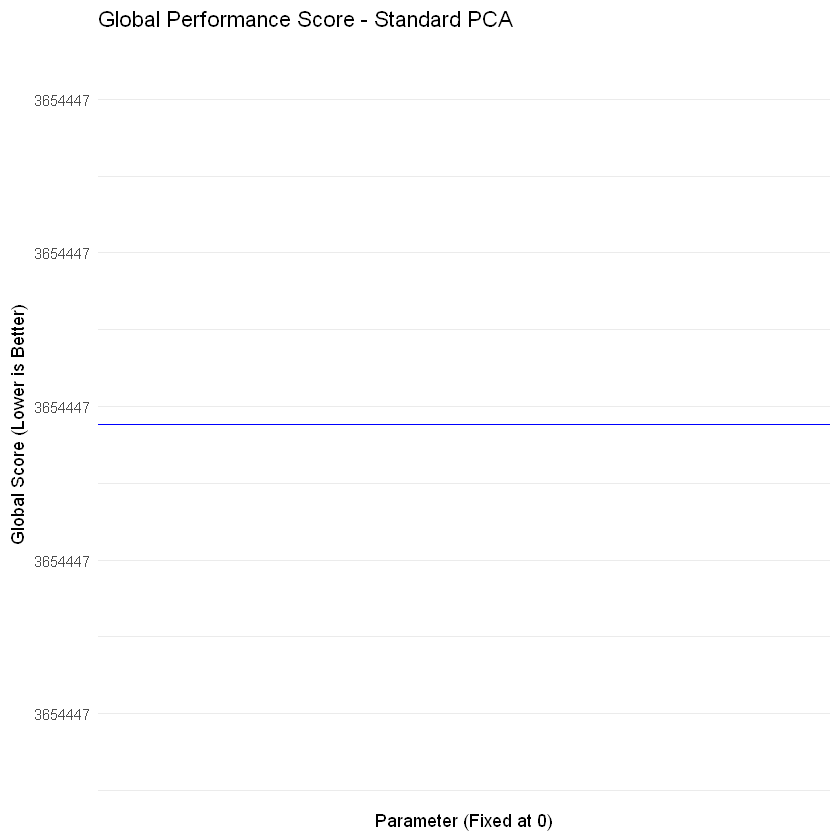

In [80]:
# Standard PCA
standardPCA <- allResults %>% filter(Method == "Standard PCA")

ggplot(standardPCA, aes(x = Parameter, y = Global_Score)) +
  geom_hline(aes(yintercept = Global_Score), color = "blue") +
  labs(title = "Global Performance Score - Standard PCA",
       x = "Parameter (Fixed at 0)",
       y = "Global Score (Lower is Better)") +
  theme_minimal()

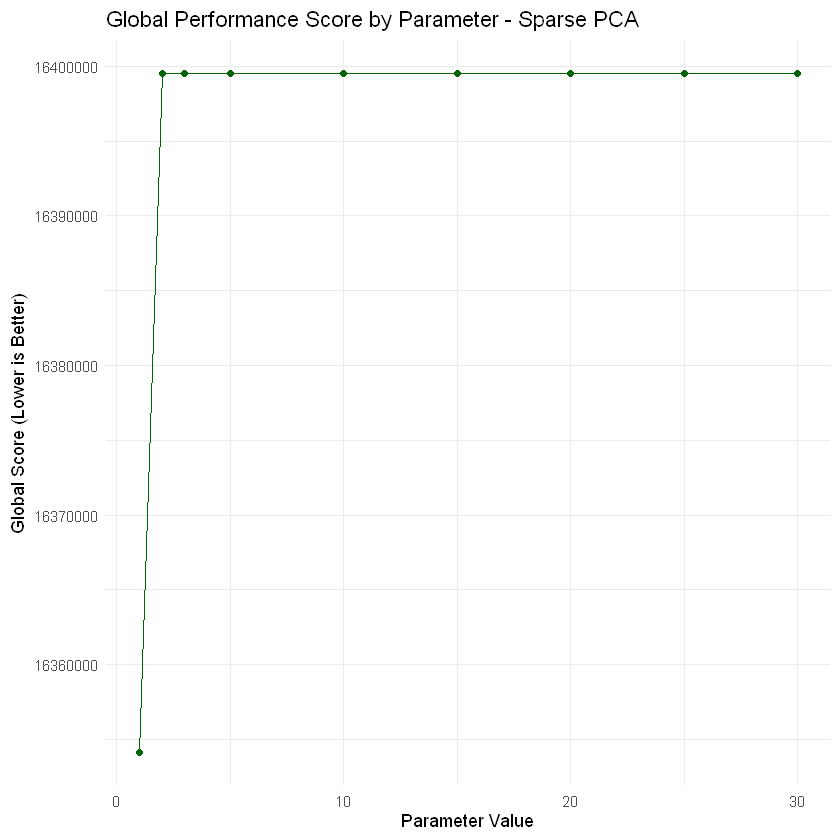

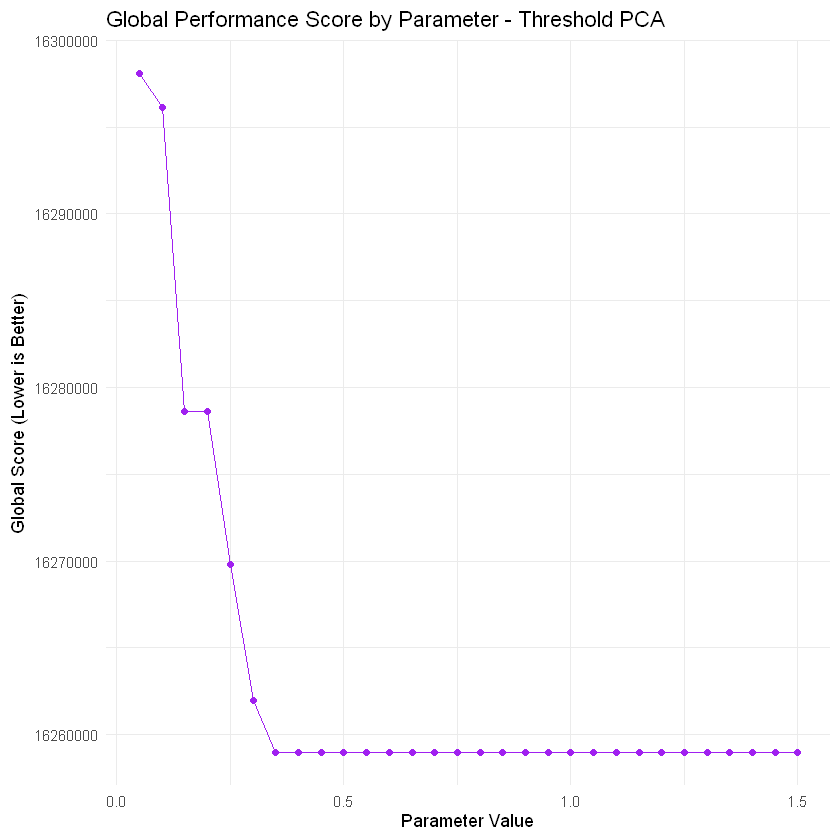

In [82]:
# Sparse PCA
sparsePCA <- allResults %>% filter(Method == "Sparse PCA")
ggplot(sparsePCA, aes(x = Parameter, y = Global_Score)) +
  geom_line(color = "darkgreen") +
  geom_point(color = "darkgreen") +
  labs(title = "Global Performance Score by Parameter - Sparse PCA",
       x = "Parameter Value",
       y = "Global Score (Lower is Better)") +
  theme_minimal()

# Threshold PCA
thresholdPCA <- allResults %>% filter(Method == "Threshold PCA")
ggplot(thresholdPCA, aes(x = Parameter, y = Global_Score)) +
  geom_line(color = "purple") +
  geom_point(color = "purple") +
  labs(title = "Global Performance Score by Parameter - Threshold PCA",
       x = "Parameter Value",
       y = "Global Score (Lower is Better)") +
  theme_minimal()

In [98]:
# Création du graphique
rmse_plot <- ggplot(results, aes(x = Method, y = RMSE, fill = Method)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(title = "RMSE Comparison by PCA Method", x = "Method", y = "RMSE") +
  theme_minimal()

# Exportation du graphique en JPEG
ggsave(
  filename = "AirPollution-RMSE_Comparison_by_PCA_Method.jpg",  # Nom du fichier
  plot = rmse_plot,                               # Objet ggplot
  device = "jpeg",                                # Format du fichier
  width = 10,                                     # Largeur (en pouces)
  height = 7,                                     # Hauteur (en pouces)
  dpi = 300                                       # Résolution (DPI pour haute qualité)
)


# 2. Bar plot of Active Variables by method
actvar <- ggplot(results, aes(x = Method, y = ActiveVariables, fill = Method)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(title = "Number of Active Variables by PCA Method", x = "Method", y = "Active Variables") +
  theme_minimal()

# Exportation du graphique en JPEG
ggsave(
  filename = "AirPollution-Number of Active Variables by PCA Method.jpg",  # Nom du fichier
  plot = actvar,                               # Objet ggplot
  device = "jpeg",                                # Format du fichier
  width = 10,                                     # Largeur (en pouces)
  height = 7,                                     # Hauteur (en pouces)
  dpi = 300                                       # Résolution (DPI pour haute qualité)
)

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


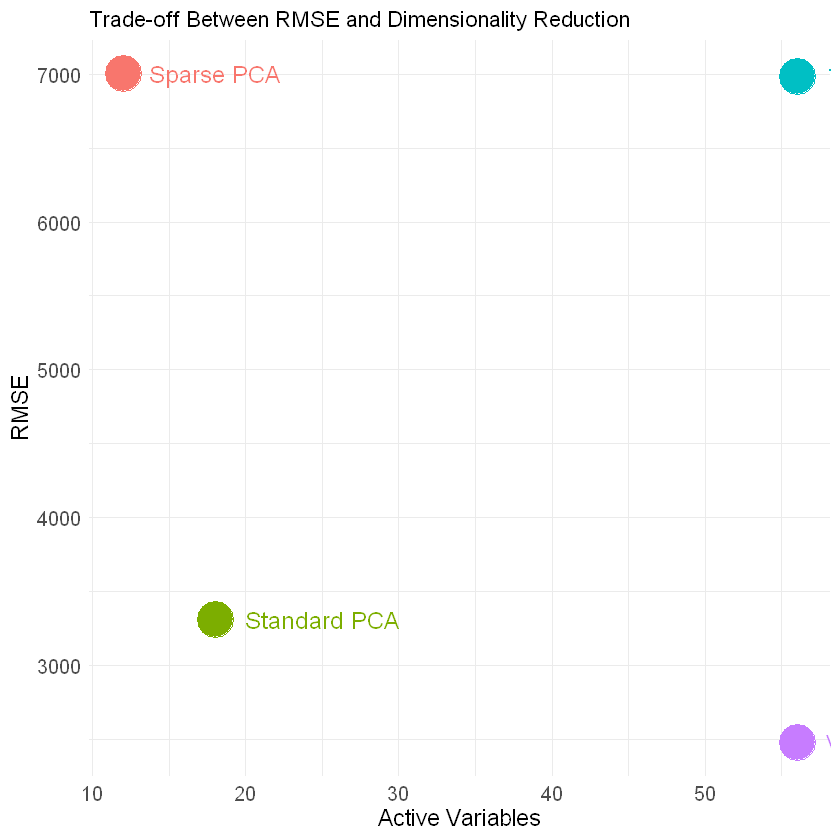

In [100]:
library(ggplot2)

data_pollution <- data.frame(
  Method = c("Standard PCA", "Variance PCA", "Sparse PCA", "Threshold PCA"),
  RMSE = c(3310.594, 2480.208, 7003.961, 6983.551),
  ActiveVariables = c(18, 56, 12, 56)
)

ggplot(data_pollution, aes(x = ActiveVariables, y = RMSE, color = Method)) +
  geom_line(size = 1.2, show.legend = FALSE) + 
  geom_point(size = 10) + 
  geom_text(aes(label = Method), hjust = -0.2, vjust = 0.5, size = 5) + 
  labs(
    title = "Trade-off Between RMSE and Dimensionality Reduction",
    x = "Active Variables",
    y = "RMSE",
    color = "Method"
  ) +
  theme_minimal() +
  theme(
    legend.position = "none",
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12)
  )


In [102]:
ggsave(
  filename = "PCA_Pollution_Tradeoff.jpg",
  plot = last_plot(),
  device = "jpeg",
  width = 10,
  height = 7,
  dpi = 300
)

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
